# Предсказание температуры стали(Промышленность)

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## **План работы**
1. Подготовка и анализ данных (EDA)
2. Предобработка данных
  - Удаление аномалий и работа с пропусками, формирование общего датасета.
  - Генерация ряда признаков.
  - Разделение общего датасета на выборки для обучения и проверки модели.
  - Масштабирование признаков - стандартизация данных
3. Обучение моделей:
  > `Линейной регрессии`,`Случайного леса`, `LightGBM`, `CatBoost`, `XGBRegressor`

  - Анализ моделей путем перекрестной проверки данных с использованием метрики показателя эффективности **MAE**
  - Обучение и подбор параметров моделей. Выбор лучшей методами:
       - **GridSearchCV**
       - **Randomized Search CV**
  - Проверка лучшей модели на тестовой выборке.
  - Исследование значимости признаков лучшей модели.
4. Выводы

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## **1. Подготовка и анализ данных (EDA)**

In [ ]:
import pandas as pd
import numpy as np
import math
import time
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, accuracy_score, mean_absolute_error,  mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from numpy.random import RandomState
from sklearn.utils import shuffle

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

In [ ]:
%%capture
# install phik (if not installed yet)
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    print('Environment: Google Colab')

!"{sys.executable}" -m pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report
from catboost import CatBoostRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

try:
    arc=pd.read_csv('/content/data_arc_new.csv', sep=',', parse_dates=[1, 2])
    bulk=pd.read_csv('/content/data_bulk_new.csv', sep=',')
    bulk_t=pd.read_csv('/content/data_bulk_time_new.csv', sep=',', parse_dates=list(range(1, 16)))
    gas=pd.read_csv('/content/data_gas_new.csv', sep=',')
    temp=pd.read_csv('/content/data_temp_new.csv', sep=',', parse_dates=[1])
    wire=pd.read_csv('/content/data_wire_new.csv', sep=',')
    wire_t=pd.read_csv('/content/data_wire_time_new.csv', sep=',', parse_dates=list(range(1, 10)))
except:
    arc=pd.read_csv('/datasets/data_arc_new.csv', sep=',', parse_dates=[1, 2])
    bulk=pd.read_csv('/datasets/data_bulk_new.csv', sep=',')
    bulk_t=pd.read_csv('/datasets/data_bulk_time_new.csv', sep=',', parse_dates=list(range(1, 16)))
    gas=pd.read_csv('/datasets/data_gas_new.csv', sep=',')
    temp=pd.read_csv('/datasets/data_temp_new.csv', sep=',', parse_dates=[1])
    wire=pd.read_csv('/datasets/data_wire_new.csv', sep=',')
    wire_t=pd.read_csv('/datasets/data_wire_time_new.csv', sep=',', parse_dates=list(range(1, 10)))

# Приведем все даенные в читаемый формат
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
#напишем функию для исследования данных
def research(data, name, figsize, silent):
    print(f'Размер данных:      {data.shape}')
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    print(f'Наличие пропусков:           {data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')
    print(round(data.isna().mean()*100).sort_values(ascending=False).head(13))
    data.info()
    if not silent:
        print(f'\nПроверка структуры {name}:')
        data.hist(linewidth=2, histtype='step', figsize=figsize)
        plt.suptitle(f'Гистограмма распеределения {name}', y=0.96, fontsize=20)
        plt.show()
        print()
        print(f'Корреляция {name}')
        display(data.corr().round(3)\
                .style\
                .background_gradient(cmap='Pastel2', low= 0, high = 1, axis = 0, subset = None))
        print()
    if silent:
        #тепловая карта корреляций
        plt.figure(figsize=figsize)
        matrix = np.triu(data.corr())
        heatmap = sns.heatmap(data.corr(), annot=True, fmt='.2g',
                          mask=matrix, square=True,
                          cmap='Pastel1',  cbar=False,
                          xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)#'coolwarm', cmap=cmap,
        plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.80) #, fontsize=25
        plt.show()
        print()
    display(data.sample(5))
    display(data.describe())

### **Данные об электродах**

Размер данных:      (14876, 5)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
key                    0.00
Начало нагрева дугой   0.00
Конец нагрева дугой    0.00
Активная мощность      0.00
Реактивная мощность    0.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

Проверка структуры данных об электродах:


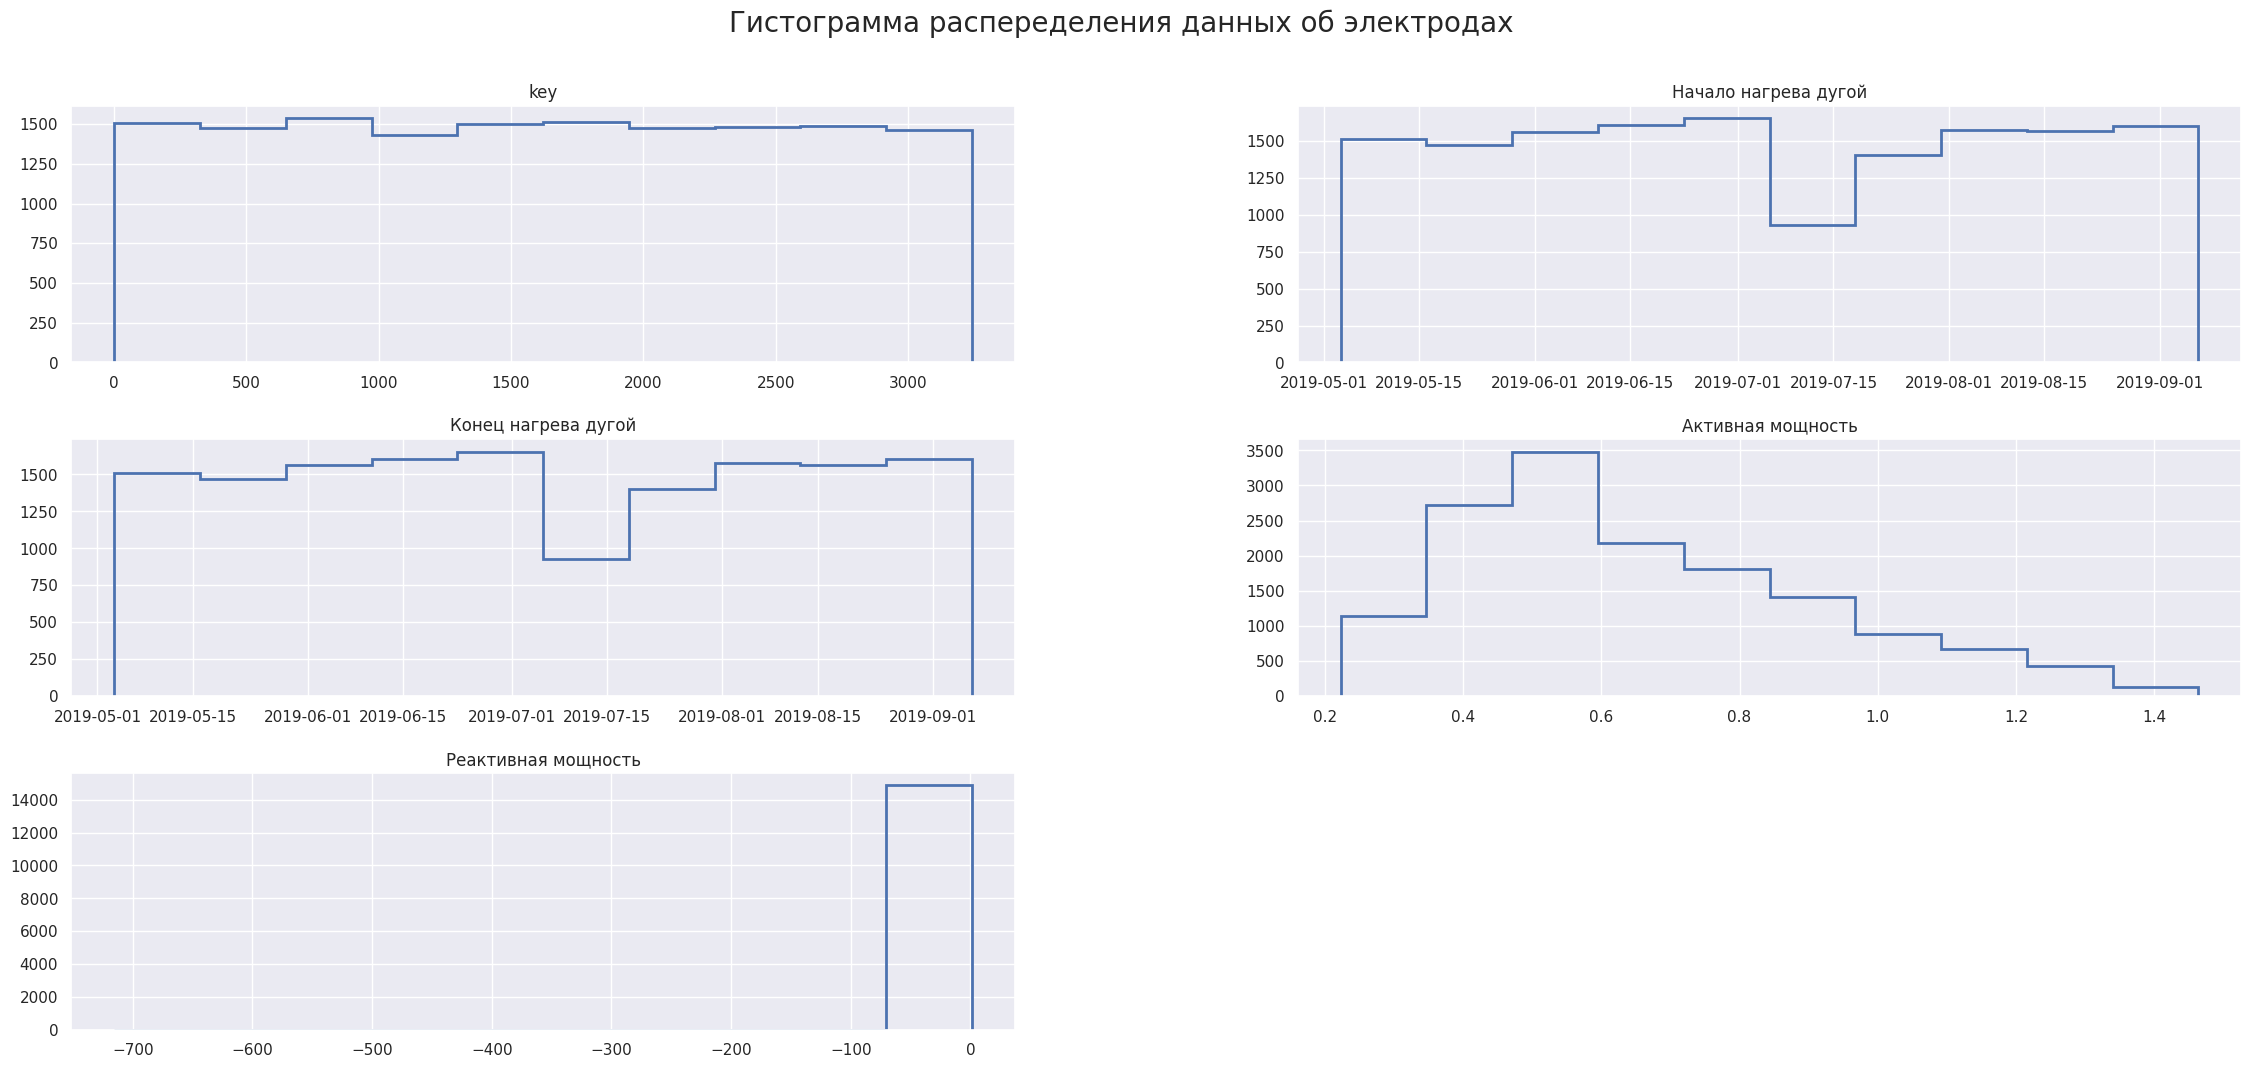


Корреляция данных об электродах


,key,Активная мощность,Реактивная мощность
key,1.000000,-0.010000,-0.005000
Активная мощность,-0.010000,1.000000,0.031000
Реактивная мощность,-0.005000,0.031000,1.000000


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
12808,2783,2019-08-21 06:14:31,2019-08-21 06:17:24,0.71,0.44
12073,2627,2019-08-15 07:13:50,2019-08-15 07:17:23,0.71,0.50
8995,1950,2019-07-21 01:44:18,2019-07-21 01:48:22,0.50,0.36
4527,975,2019-06-10 03:59:00,2019-06-10 04:01:05,0.35,0.24
83,18,2019-05-04 00:10:36,2019-05-04 00:11:37,0.87,0.71


,key,Активная мощность,Реактивная мощность
count,"14,876.00","14,876.00","14,876.00"
mean,"1,615.22",0.66,0.44
std,934.57,0.26,5.87
min,1.00,0.22,-715.48
25%,806.00,0.47,0.34
50%,"1,617.00",0.60,0.44
75%,"2,429.00",0.83,0.61
max,"3,241.00",1.46,1.27


In [ ]:
research(arc, 'данных об электродах', figsize=(28,12), silent=False)

In [ ]:
#Визуализируем наши данные
def feed_size(data, state, name_state, x_lim0, x_lim): #, data_test
    print(f'Статистические данные о распределении значений {name_state} ({state}):')
    display(data[f'{state}'].describe())
    plt.subplots(figsize=(12, 1))
    plt.xlim([x_lim0, x_lim])
    plt.title(f'Диаграмма рассеяния {name_state} ({state})')
    sns.boxplot(x=data[f'{state}'], palette='pastel', data=data[f'{state}'])
    plt.show()
    plt.figure(figsize=(12, 2))
    #sns.kdeplot(data[f'{state}'], fill=True, label=f'{state} {name_state}', alpha=0.6, shade=True)
    sns.histplot(data[f'{state}'], color="seagreen", label=f'{state}', alpha=0.7, kde=True)
    plt.xlim([x_lim0, x_lim])
    plt.xlabel(f'{state}')
    plt.ylabel(f'Распределение вероятности \nнепрерывной величины')
    plt.legend(loc='upper right')
    plt.title(f'Гистограмма распределения {name_state} ({state})', fontsize=12)
    plt.show()

Статистические данные о распределении значений данных об электродах (Активная мощность):


count   14,876.00
mean         0.66
std          0.26
min          0.22
25%          0.47
50%          0.60
75%          0.83
max          1.46
Name: Активная мощность, dtype: float64

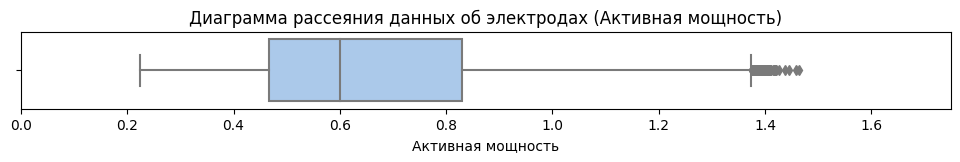

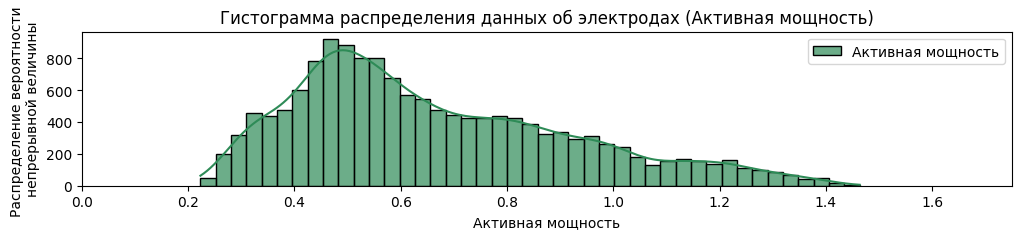

In [ ]:
feed_size(arc, 'Активная мощность', 'данных об электродах', 0, 1.75)

Статистические данные о распределении значений данных об электродах (Реактивная мощность):


count   14,876.00
mean         0.44
std          5.87
min       -715.48
25%          0.34
50%          0.44
75%          0.61
max          1.27
Name: Реактивная мощность, dtype: float64

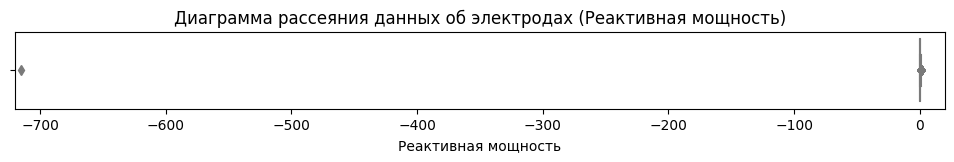

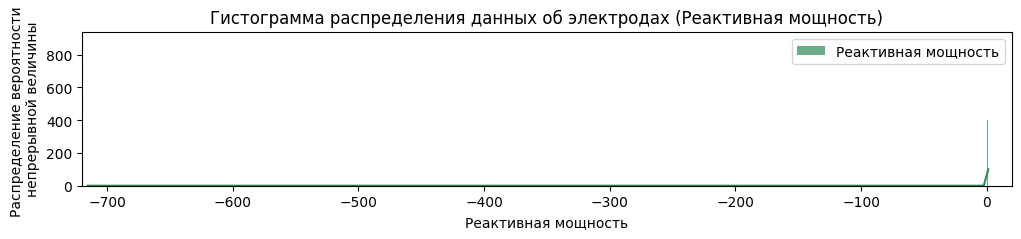

In [ ]:
feed_size(arc, 'Реактивная мощность', 'данных об электродах', -720, 20)

явный выброс на -700

In [ ]:
#найдем явный выброс - мощность не может быть отрицательной
arc[arc['Реактивная мощность']<=0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.71,-715.48


Статистические данные о распределении значений данных об электродах (Реактивная мощность):


count   14,875.00
mean         0.49
std          0.20
min          0.15
25%          0.34
50%          0.44
75%          0.61
max          1.27
Name: Реактивная мощность, dtype: float64

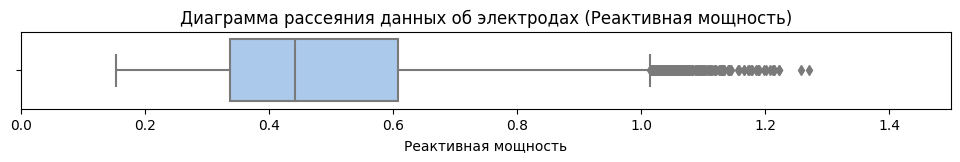

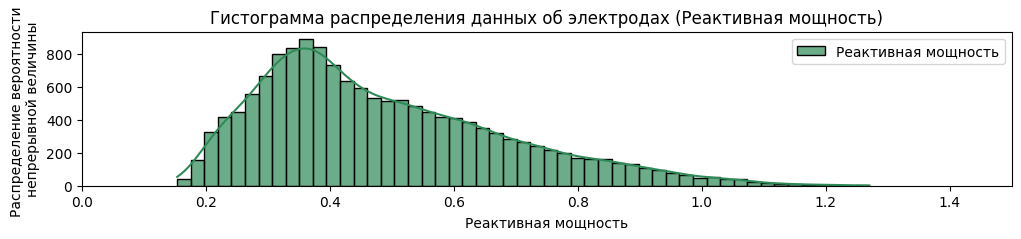

In [ ]:
feed_size(arc[arc['Реактивная мощность']>0], 'Реактивная мощность', 'данных об электродах', 0, 1.5)

In [ ]:
#Гистограмму для признака 'Начало нагрева дугой'
def res_graph (data, name): #, period
    sns.set(rc={"figure.figsize": (30, 5)})
    sns.set_style("dark")
    ahs = sns.histplot(data=data, x=name, kde=True, discrete=True)
    ahs.set_ylabel('Количество строк')
    ahs.set_title(f'Гистограмма распределения времени {name}')

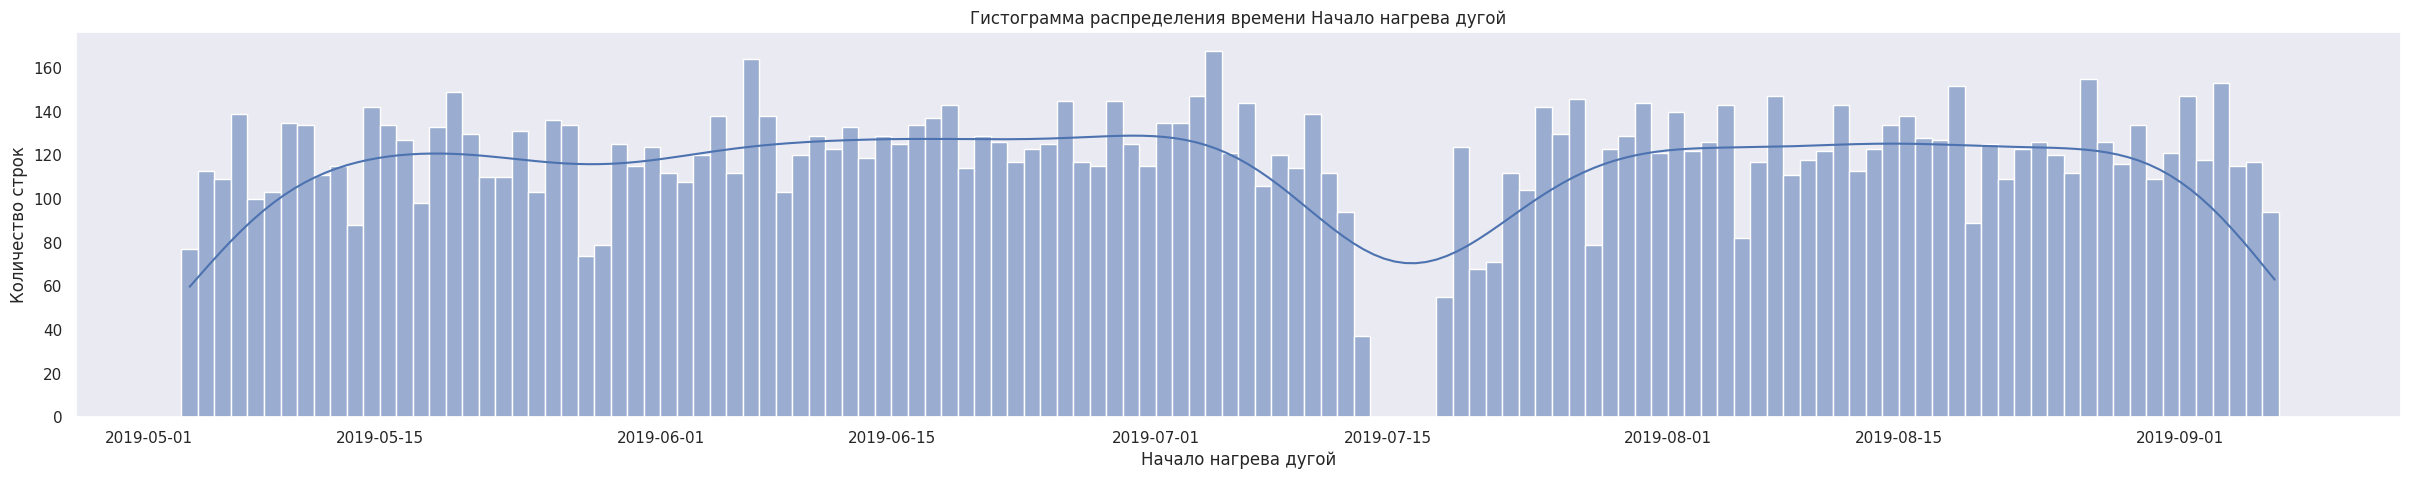

In [ ]:
res_graph (arc, 'Начало нагрева дугой')

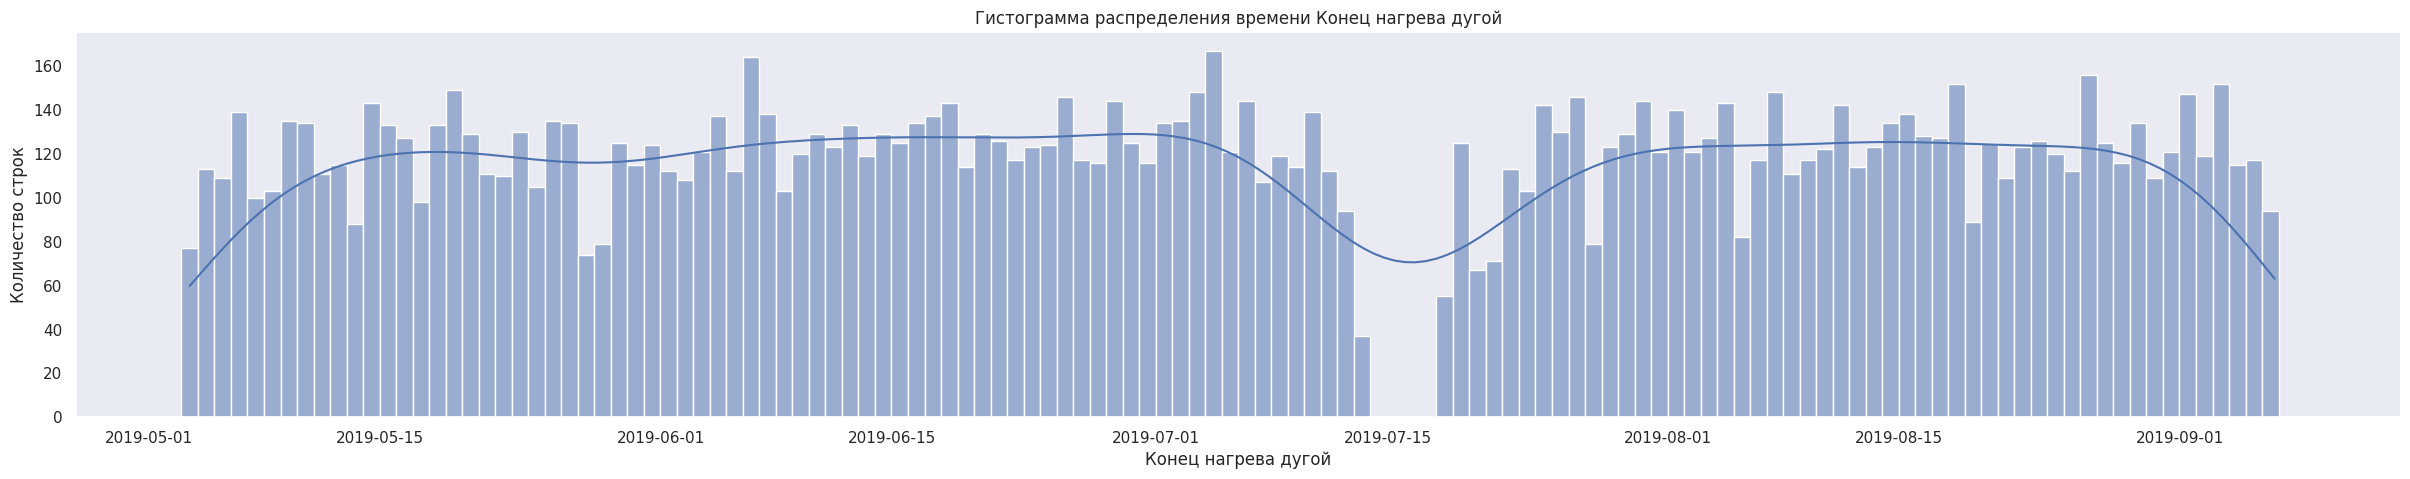

In [ ]:
res_graph (arc, 'Конец нагрева дугой')

- Явно наблюдается отсутствие работы электродов в июле месяце - возможно был технический сбой

### **Данные о продувке сплава газом**

Размер данных:      (3239, 2)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
key     0.00
Газ 1   0.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Проверка структуры данных о продувке сплава газом:


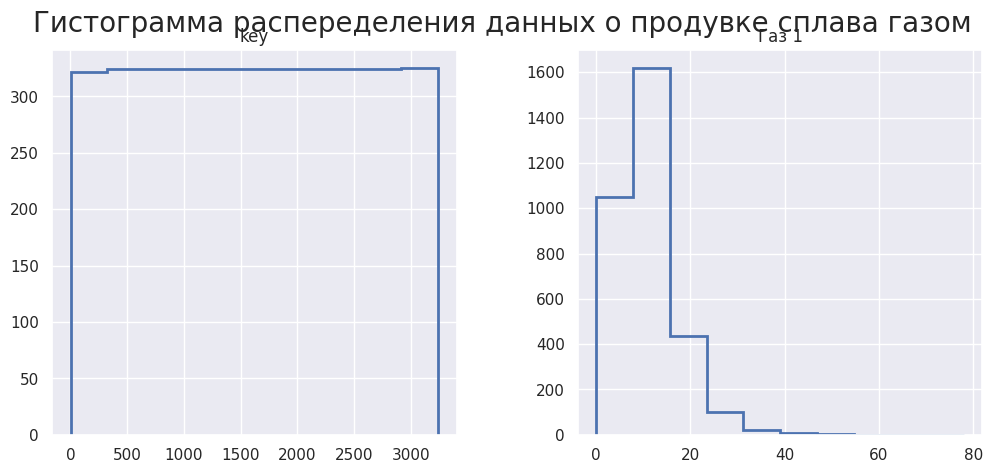


Корреляция данных о продувке сплава газом


,key,Газ 1
key,1.000000,-0.041000
Газ 1,-0.041000,1.000000


,key,Газ 1
2401,2404,14.35
1724,1727,35.36
648,651,9.91
1381,1384,7.28
1638,1641,16.58


,key,Газ 1
count,"3,239.00","3,239.00"
mean,"1,621.86",11.00
std,935.39,6.22
min,1.00,0.01
25%,812.50,7.04
50%,"1,622.00",9.84
75%,"2,431.50",13.77
max,"3,241.00",78.00


In [ ]:
research(gas, 'данных о продувке сплава газом', figsize=(12,5), silent=False)

Статистические данные о распределении значений данных о продувке сплава газом (Газ 1):


count   3,239.00
mean       11.00
std         6.22
min         0.01
25%         7.04
50%         9.84
75%        13.77
max        78.00
Name: Газ 1, dtype: float64

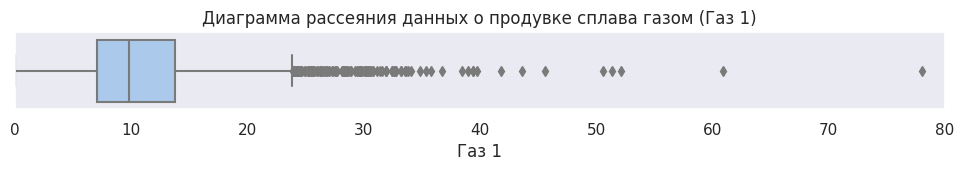

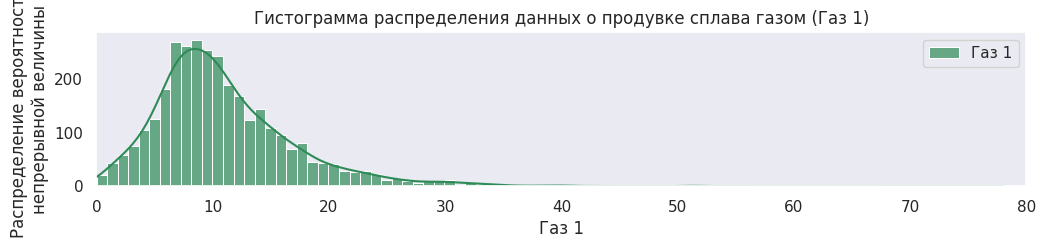

In [ ]:
feed_size(gas, 'Газ 1', 'данных о продувке сплава газом', 0, 80)

- Явных дубликатов и пропусков не наблюдается
- Распределение данных о продувке сплава газом - нормальное со смещением влево

### **Результаты измерения температуры**

Размер данных:      (2473, 5)
Количество явных дубликатов: 0
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
key        0.00
mesure_1   0.00
mesure_2   0.00
temp_1     0.00
temp_2     0.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       2473 non-null   int64         
 1   mesure_1  2473 non-null   datetime64[ns]
 2   mesure_2  2473 non-null   datetime64[ns]
 3   temp_1    2473 non-null   float64       
 4   temp_2    2473 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 96.7 KB

Проверка структуры результатов измерения температуры:


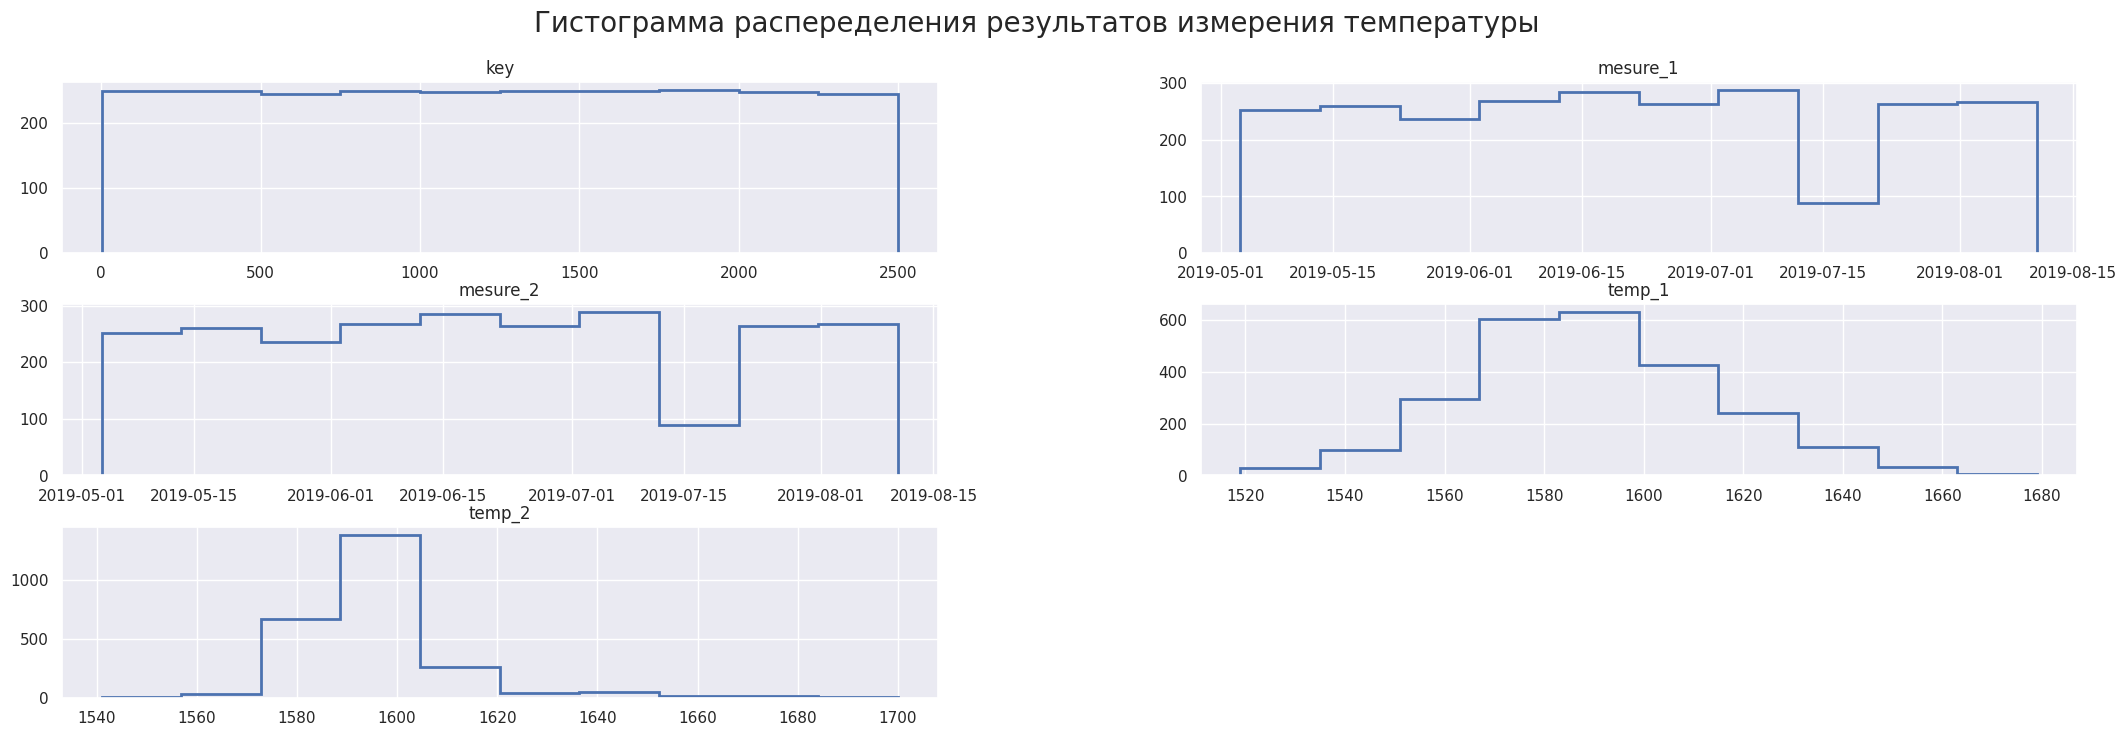


Корреляция результатов измерения температуры


,key,temp_1,temp_2
key,1.000000,-0.015000,-0.081000
temp_1,-0.015000,1.000000,0.438000
temp_2,-0.081000,0.438000,1.000000


,key,mesure_1,mesure_2,temp_1,temp_2
1975,1993,2019-07-23 03:42:33,2019-07-23 04:29:25,"1,636.00","1,593.00"
1639,1657,2019-07-04 07:20:24,2019-07-04 07:46:11,"1,566.00","1,583.00"
2465,2492,2019-08-10 09:34:35,2019-08-10 10:15:13,"1,618.00","1,595.00"
904,917,2019-06-07 23:01:34,2019-06-08 00:00:52,"1,598.00","1,593.00"
2106,2127,2019-07-28 10:21:59,2019-07-28 10:38:29,"1,580.00","1,597.00"


,key,temp_1,temp_2
count,"2,473.00","2,473.00","2,473.00"
mean,"1,249.66","1,589.02","1,595.34"
std,720.40,25.00,16.03
min,1.00,"1,519.00","1,541.00"
25%,627.00,"1,572.00","1,587.00"
50%,"1,251.00","1,588.00","1,593.00"
75%,"1,872.00","1,605.00","1,599.00"
max,"2,499.00","1,679.00","1,700.00"


In [ ]:
research(temp, 'результатов измерения температуры', figsize=(26,8), silent=False)

Статистические данные о распределении значений результатов измерения температуры (Температура):


count   14,665.00
mean     1,590.72
std         20.39
min      1,191.00
25%      1,580.00
50%      1,590.00
75%      1,599.00
max      1,705.00
Name: Температура, dtype: float64

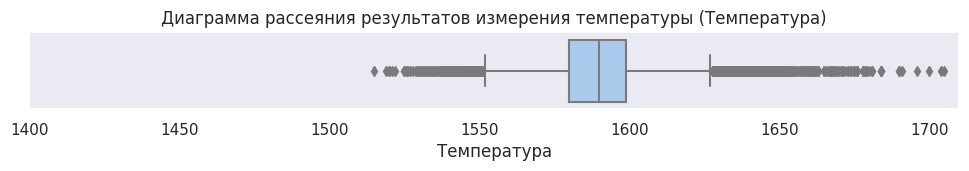

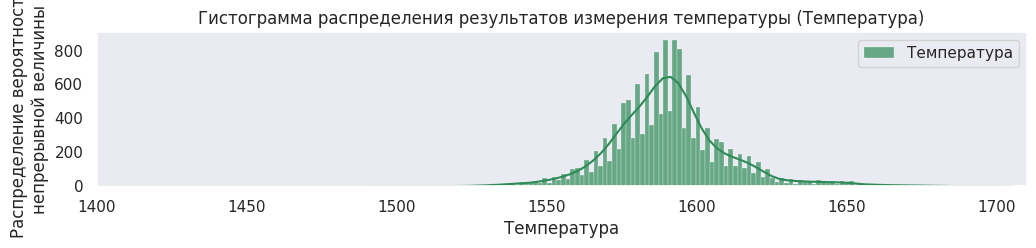

In [ ]:
feed_size(temp, 'Температура', 'результатов измерения температуры', 1400, 1710)

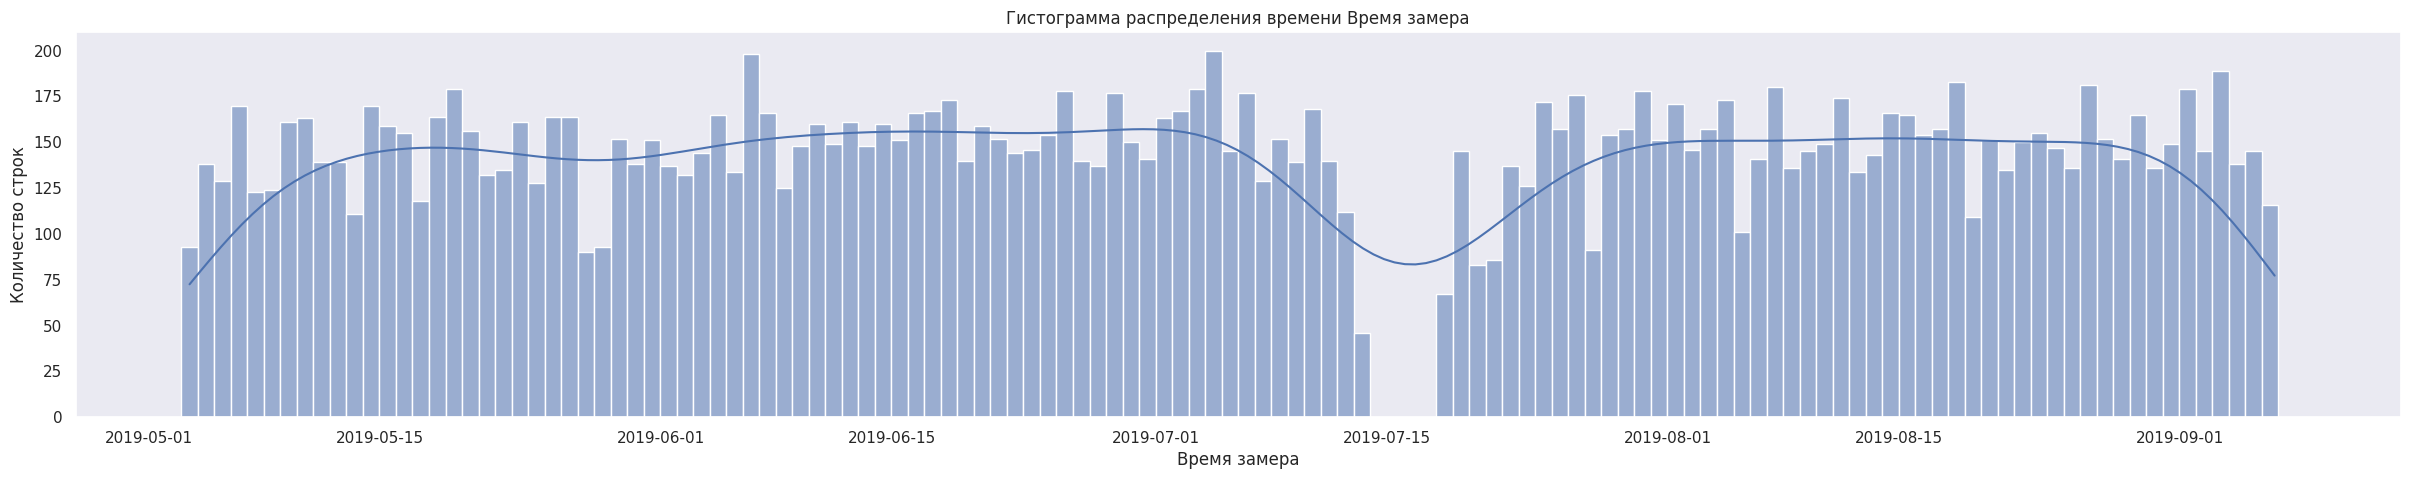

In [ ]:
res_graph (temp, 'Время замера')

- в столбце Температура 19% пропущенных данных
- распределение данных нормальное
- также наблюдается некий простой в работе в июле месяце (что соответствует данным работы электродов)
- так как температура плавления стали 1450-1520°С поэтому в нашем датасете считаем температуру ниже 1450°С - выбросом - в дальнейшем удалим.
- нетипичных выбросов более высоких температур не наблюдается, так как температура плавления некоторых тугоплавких металлов и сплавов может превышать 1600 градусов (видимо их используют не так часто): Титан (+1680°С), Платина (+1769,3°С), Хром (+1907°С).

### **Данные о подаче сыпучих материалов (объем)**

Размер данных:      (3129, 16)
Количество явных дубликатов: 0
Наличие пропусков:           35776
Пропущенные данные (в процентном соотношении):
Bulk 8    100.00
Bulk 2     99.00
Bulk 7     99.00
Bulk 9     99.00
Bulk 13    99.00
Bulk 5     98.00
Bulk 10    94.00
Bulk 11    94.00
Bulk 1     92.00
Bulk 6     82.00
Bulk 4     68.00
Bulk 3     59.00
Bulk 15    28.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 n

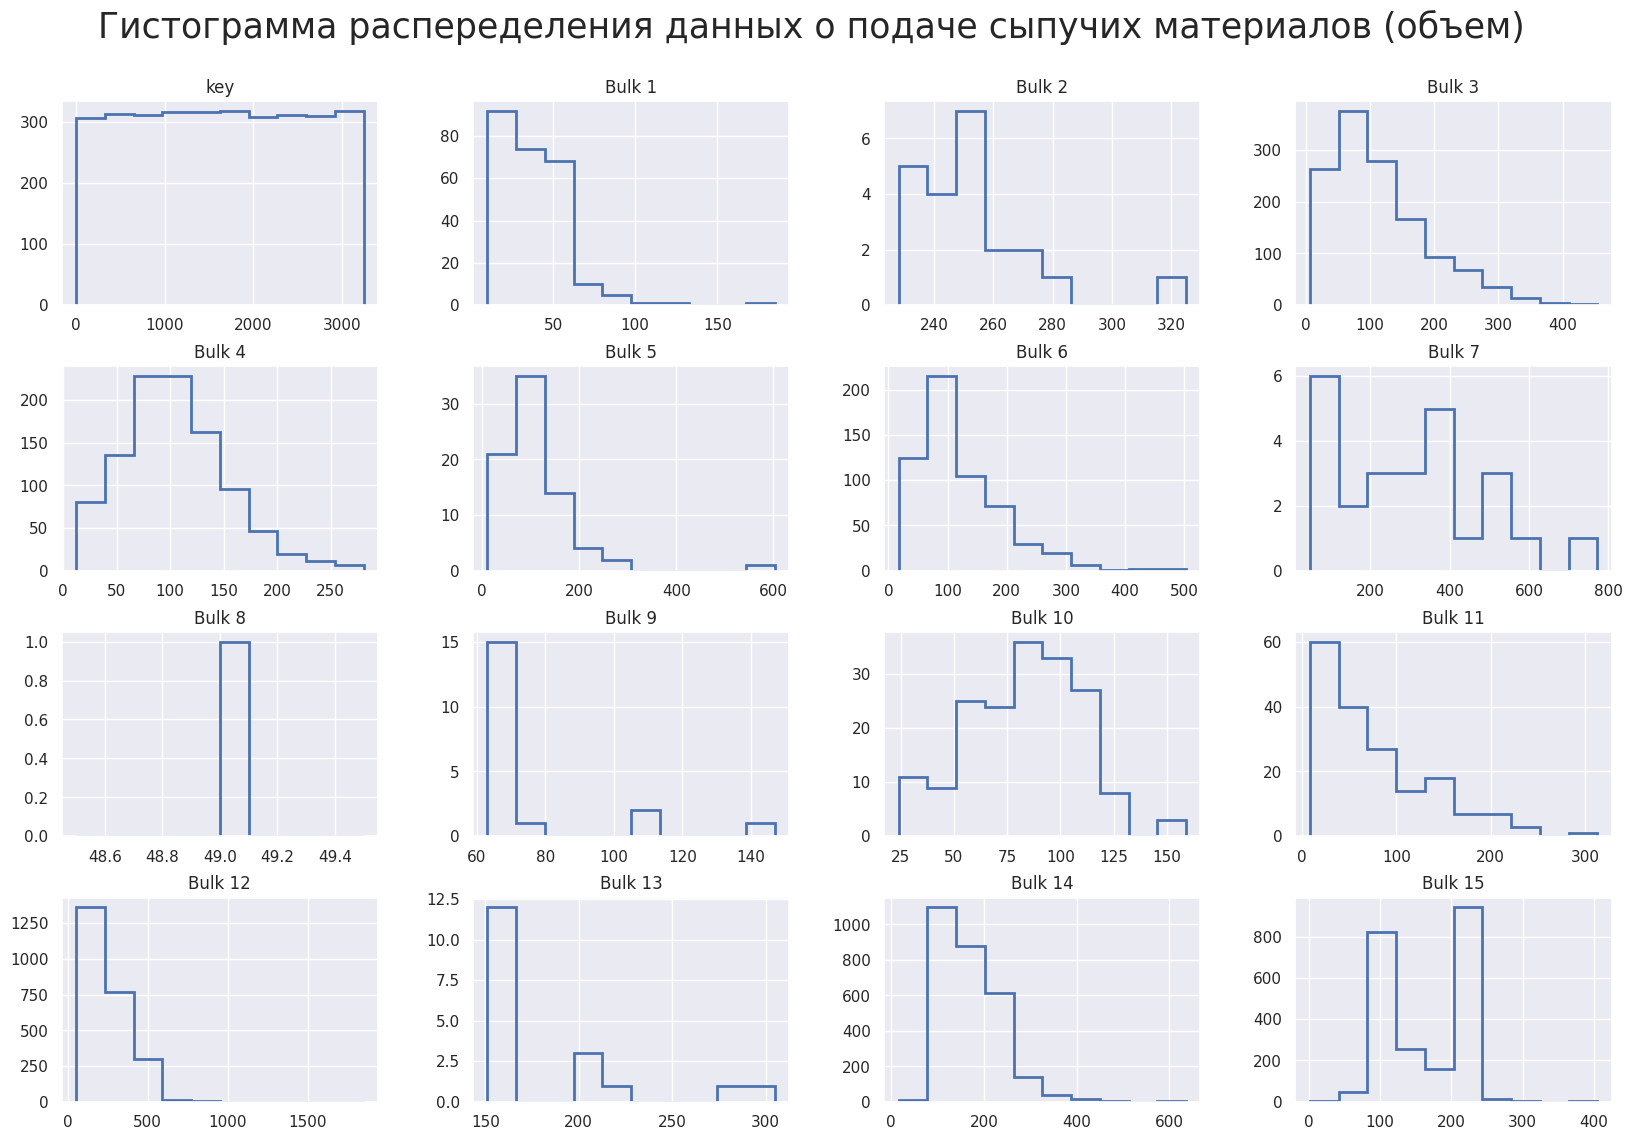


Корреляция данных о подаче сыпучих материалов (объем)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,1.000000,-0.192000,-0.039000,-0.080000,-0.102000,-0.018000,-0.064000,-0.049000,nan,0.263000,0.288000,-0.157000,-0.031000,0.050000,-0.150000,-0.170000
Bulk 1,-0.192000,1.000000,-0.074000,0.017000,-0.040000,-0.369000,0.142000,-0.086000,nan,nan,-0.278000,0.462000,0.371000,1.000000,0.409000,-0.119000
Bulk 2,-0.039000,-0.074000,1.000000,nan,0.394000,0.070000,nan,-0.010000,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 3,-0.080000,0.017000,nan,1.000000,-0.261000,0.144000,0.253000,nan,nan,0.073000,-0.245000,0.138000,0.012000,-0.583000,0.026000,-0.024000
Bulk 4,-0.102000,-0.040000,0.394000,-0.261000,1.000000,-0.077000,-0.334000,0.325000,nan,0.767000,-0.516000,nan,0.051000,-0.312000,0.023000,0.041000
Bulk 5,-0.018000,-0.369000,0.070000,0.144000,-0.077000,1.000000,-0.511000,0.304000,nan,nan,nan,nan,0.008000,nan,-0.256000,-0.248000
Bulk 6,-0.064000,0.142000,nan,0.253000,-0.334000,-0.511000,1.000000,nan,nan,nan,nan,-0.104000,-0.080000,0.845000,0.154000,-0.038000
Bulk 7,-0.049000,-0.086000,-0.010000,nan,0.325000,0.304000,nan,1.000000,nan,nan,nan,nan,0.539000,nan,1.000000,nan
Bulk 8,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 9,0.263000,nan,nan,0.073000,0.767000,nan,nan,nan,nan,1.000000,nan,nan,0.947000,nan,-0.480000,nan


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2652,2753,NaN,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.00,NaN,222.00,104.00
301,320,NaN,NaN,NaN,NaN,NaN,297.00,NaN,NaN,NaN,NaN,NaN,105.00,NaN,300.00,102.00
1272,1323,NaN,NaN,98.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.00,NaN,206.00,211.00
484,511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,135.00,203.00
1966,2035,NaN,NaN,NaN,NaN,NaN,140.00,NaN,NaN,NaN,NaN,NaN,391.00,NaN,110.00,226.00


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,"3,129.00",252.00,22.00,"1,298.00","1,014.00",77.00,576.00,25.00,1.00,19.00,176.00,177.00,"2,450.00",18.00,"2,806.00","2,248.00"
mean,"1,624.38",39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.00,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.00,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.00,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,"1,622.00",31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.00,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,"2,431.00",46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.00,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,"3,241.00",185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.00,147.00,159.00,313.00,"1,849.00",305.00,636.00,405.00


In [ ]:
research(bulk, 'данных о подаче сыпучих материалов (объем)', figsize=(20,13), silent=False)

Статистические данные о распределении значений данных о подаче сыпучих материалов (объем) (Bulk 10):


count   176.00
mean     83.28
std      26.06
min      24.00
25%      64.00
50%      86.50
75%     102.00
max     159.00
Name: Bulk 10, dtype: float64

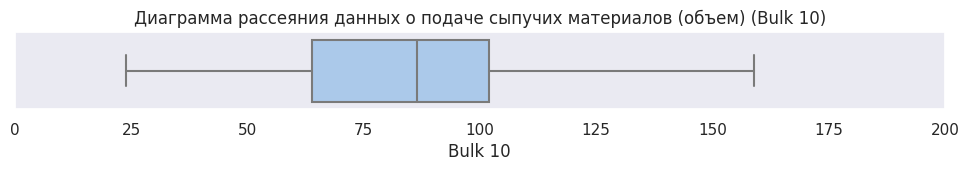

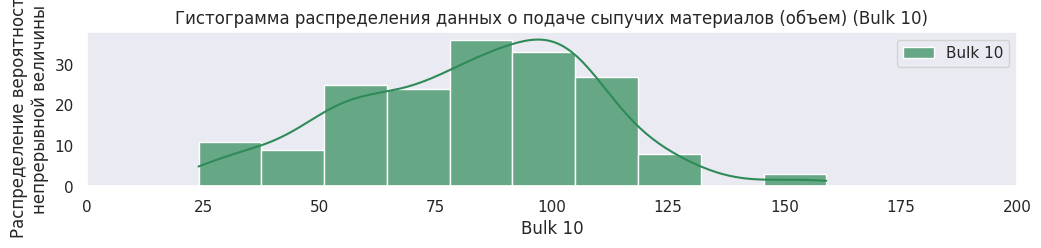

In [ ]:
feed_size(bulk, 'Bulk 10', 'данных о подаче сыпучих материалов (объем)', 0, 200)

- Нормальное распределение характерно для Bulk_4 и Bulk_6. Для Bulk_3 и Bulk_5 характерно нормальное распределение со сдвигом влево.
Для других характерны доминанты определенных значений с характерными пиками на графиках распределения.
- Из данных видно, что сыпучие материалы добавляются в разных объемах:
    - меньше всего в среднем добавляют Bulk 1,
    - больше всего в среднем - Bulk 7.
    - чаще всего добавляют Bulk 14,
    - только 1 раз добавили Bulk 8.

> То есть разные сыпучие материалы (легирующие добавки) по-разному действуют на металл, а Bulk 8 либо крайне редко использующаяся легирующая добавка, либо крайне дорогая, либо и то, и то.

In [ ]:
def boxplots (data, name_state, state):
  plt.figure(figsize=(15,5))
  plt.title(f'Диаграмма рассеяния {name_state} ({state})')
  sns.boxplot(data=data)
  plt.grid();

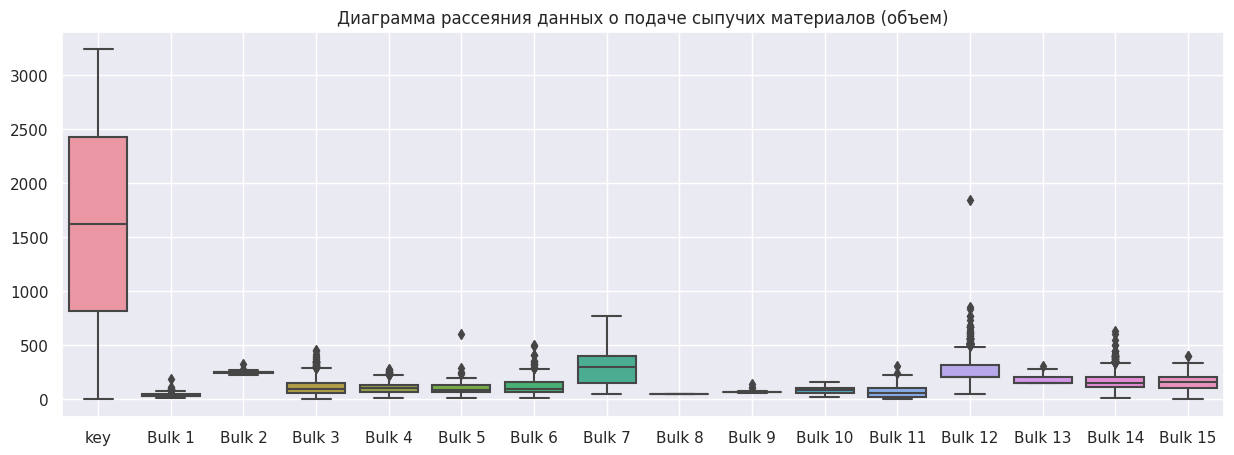

In [ ]:
boxplots (bulk, 'данных о подаче сыпучих материалов', 'объем')

Выбросы незначительные присутствуют, также много пропусков, но они могут быть обусловлены технологическим процессом, поэтому имеет смысл заменить пропуски - 0.

### **Данные о подаче сыпучих материалов (время)**

Размер данных:      (3129, 16)
Количество явных дубликатов: 0
Наличие пропусков:           35776
Пропущенные данные (в процентном соотношении):
Bulk 8    100.00
Bulk 2     99.00
Bulk 7     99.00
Bulk 9     99.00
Bulk 13    99.00
Bulk 5     98.00
Bulk 10    94.00
Bulk 11    94.00
Bulk 1     92.00
Bulk 6     82.00
Bulk 4     68.00
Bulk 3     59.00
Bulk 15    28.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 n

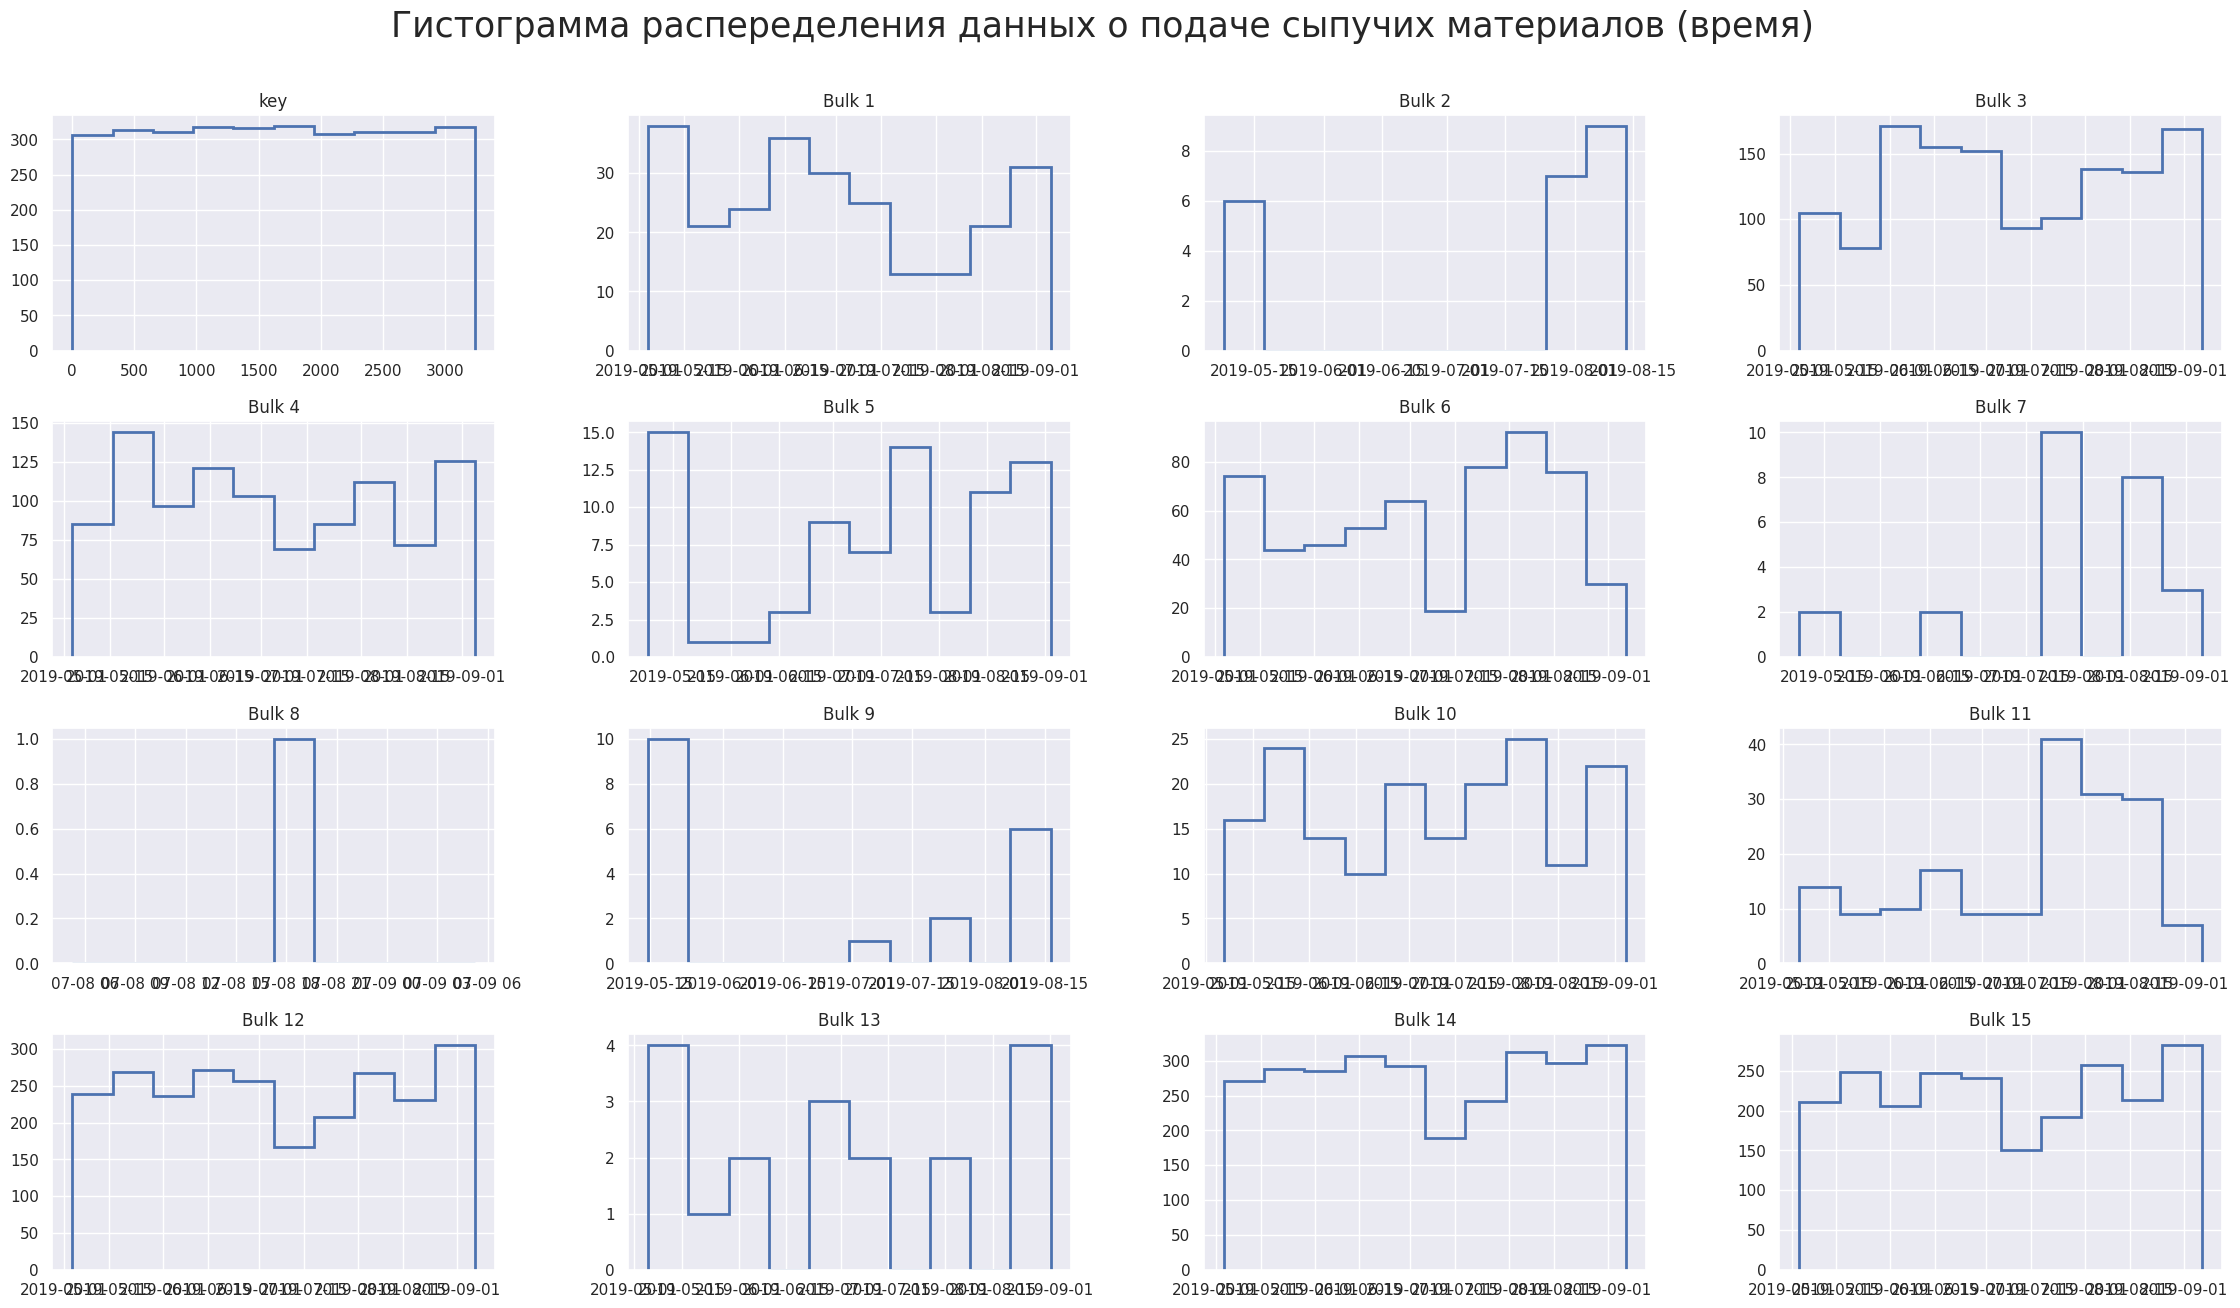


Корреляция данных о подаче сыпучих материалов (время)


,key
key,1.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2530,2627,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-15 07:17:37,NaT
2088,2160,NaT,NaT,2019-07-29 14:02:00,2019-07-29 14:02:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-07-29 14:12:22,NaT,2019-07-29 14:12:22,2019-07-29 14:12:22
2173,2252,NaT,NaT,NaT,2019-08-01 14:30:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-01 14:39:19,NaT,2019-08-01 14:34:51,2019-08-01 14:30:05
2211,2291,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-02 23:57:20,NaT,2019-08-02 23:57:20,2019-08-02 23:53:05
573,602,NaT,NaT,2019-05-26 06:51:18,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-26 06:51:18,NaT,2019-05-26 06:47:21,2019-05-26 06:40:57


,key
count,"3,129.00"
mean,"1,624.38"
std,933.34
min,1.00
25%,816.00
50%,"1,622.00"
75%,"2,431.00"
max,"3,241.00"


In [ ]:
research(bulk_t, 'данных о подаче сыпучих материалов (время)', figsize=(28,15), silent=False)

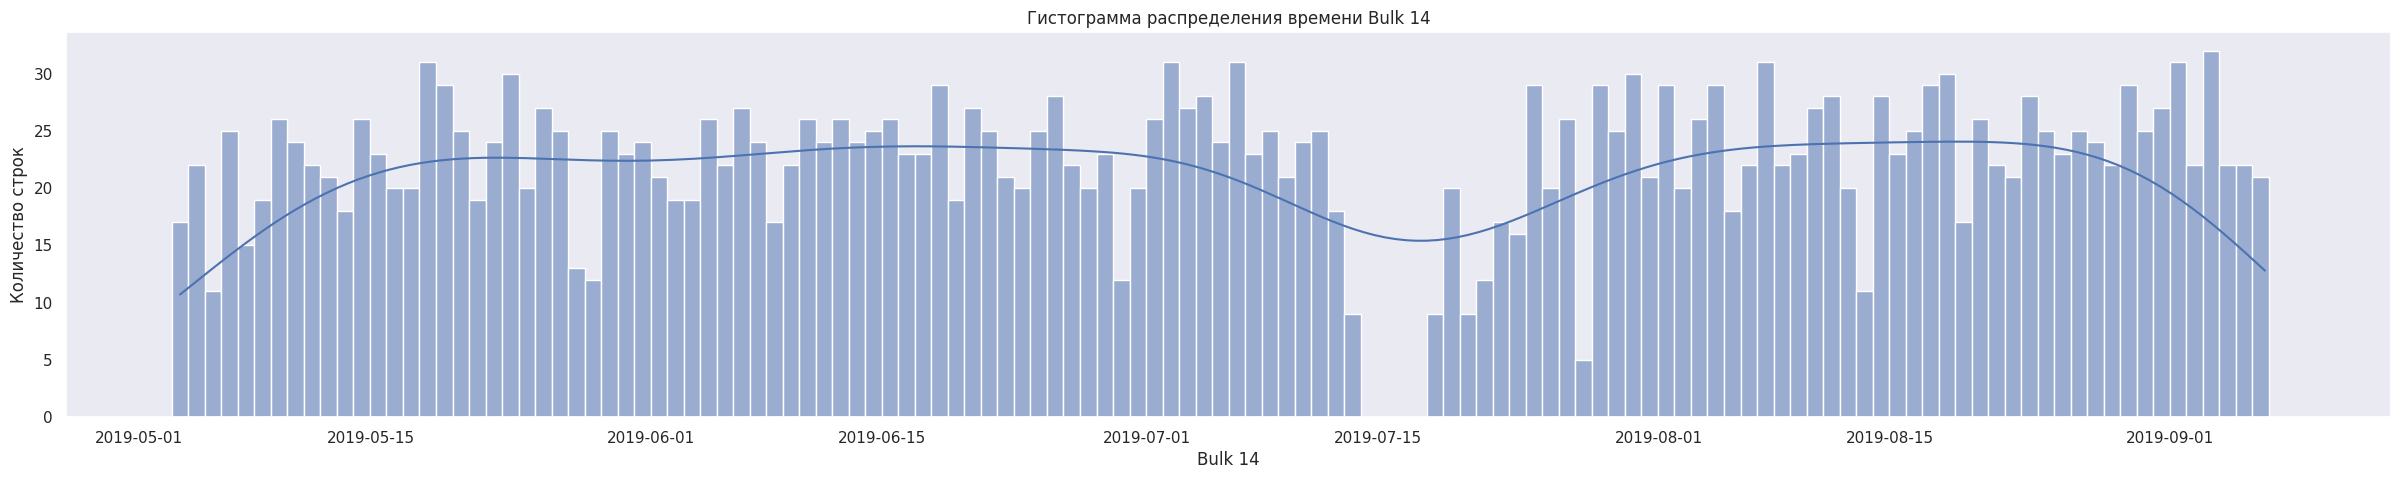

In [ ]:
res_graph (bulk_t, 'Bulk 14')

- также наблюдается неравномерное распределение, как и в случае с объемами.
- опять же видим подтверждение времени простоя в июле.

### **Данные о проволочных материалах (объем)**

Размер данных:      (3081, 10)
Количество явных дубликатов: 0
Наличие пропусков:           23385
Пропущенные данные (в процентном соотношении):
Wire 4   100.00
Wire 5   100.00
Wire 7   100.00
Wire 8    99.00
Wire 9    99.00
Wire 3    98.00
Wire 6    98.00
Wire 2    65.00
Wire 1     1.00
key        0.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Проверка структуры данных о проволочных материалах (объем):


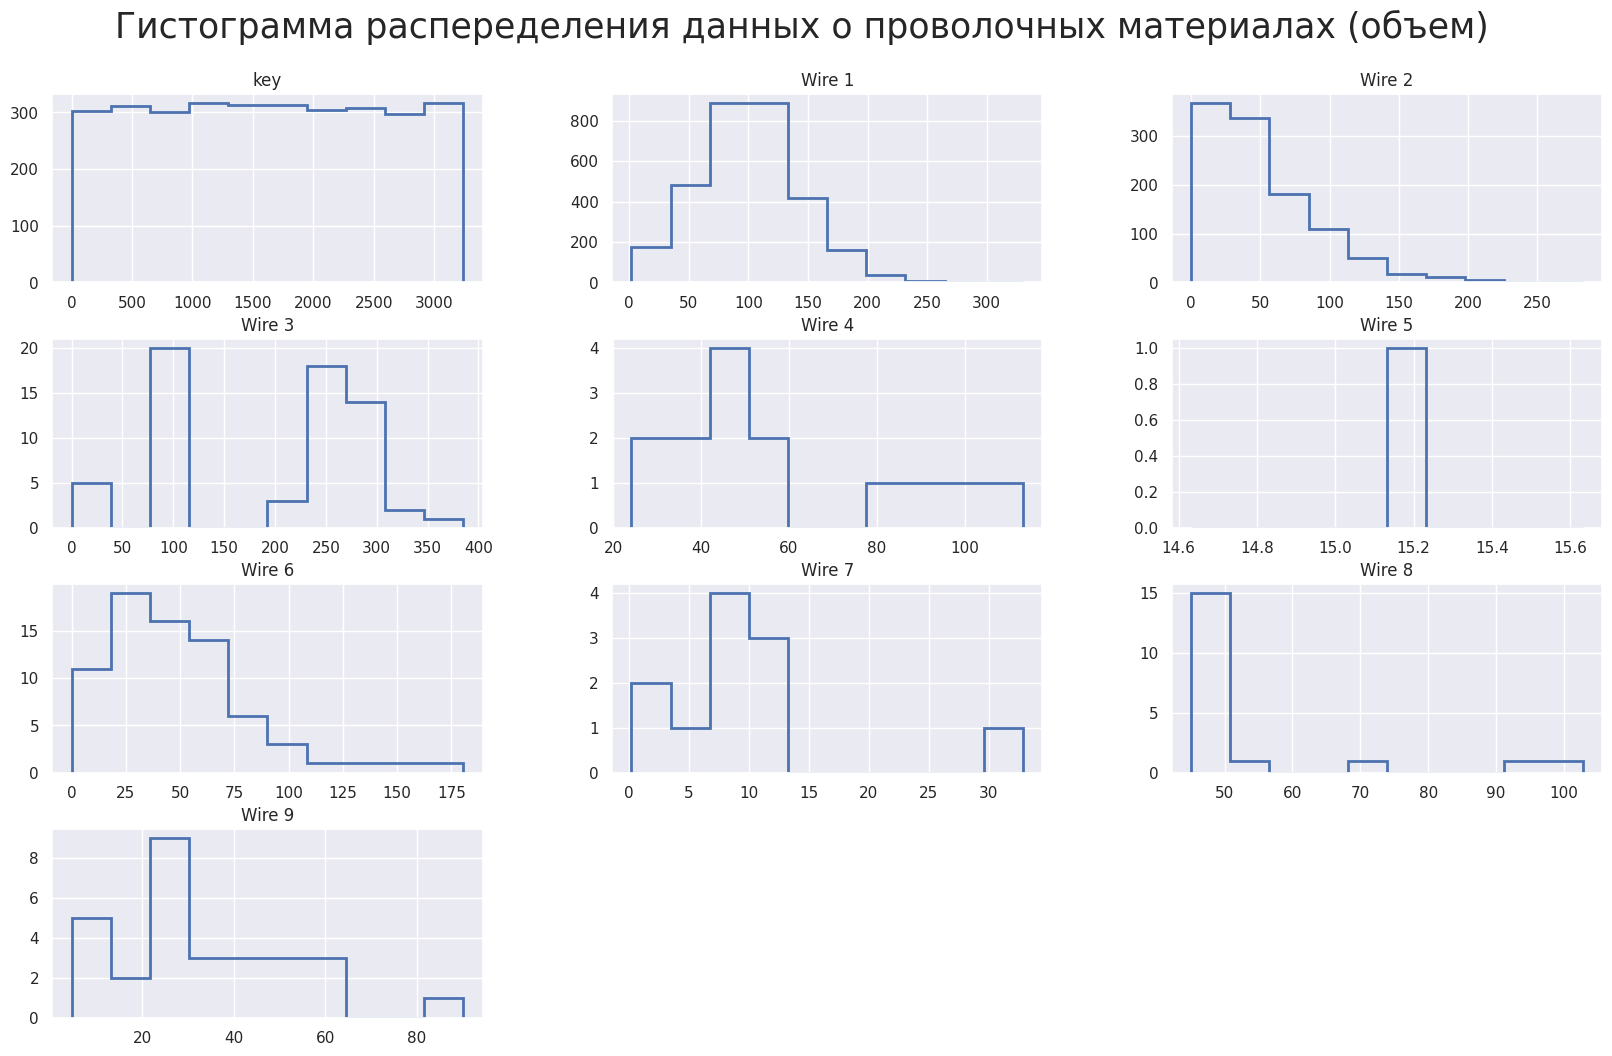


Корреляция данных о проволочных материалах (объем)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.083000,-0.005000,-0.084000,0.389000,nan,0.082000,0.579000,0.324000,-0.012000
Wire 1,-0.083000,1.000000,-0.031000,0.724000,0.054000,nan,-0.281000,-0.035000,0.069000,0.010000
Wire 2,-0.005000,-0.031000,1.000000,-0.082000,nan,nan,-0.266000,nan,0.250000,0.011000
Wire 3,-0.084000,0.724000,-0.082000,1.000000,0.070000,nan,-0.222000,-0.057000,nan,nan
Wire 4,0.389000,0.054000,nan,0.070000,1.000000,nan,0.237000,-0.405000,nan,nan
Wire 5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wire 6,0.082000,-0.281000,-0.266000,-0.222000,0.237000,nan,1.000000,-0.224000,nan,nan
Wire 7,0.579000,-0.035000,nan,-0.057000,-0.405000,nan,-0.224000,1.000000,nan,nan
Wire 8,0.324000,0.069000,0.250000,nan,nan,nan,nan,nan,1.000000,nan
Wire 9,-0.012000,0.010000,0.011000,nan,nan,nan,nan,nan,nan,1.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
49,58,73.21,11.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1359,1430,176.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1288,1357,105.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1345,1416,70.01,72.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,328,96.88,40.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,"3,081.00","3,055.00","1,079.00",63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,"1,623.43",100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,"1,619.00",100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,"2,434.00",126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,"3,241.00",330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


In [ ]:
research(wire, 'данных о проволочных материалах (объем)', figsize=(20,12), silent=False)

- Много пропущенных данных, вероятно не все данные фиксировались.
- Видим отсутствие данных в столбцах Wire 4, Wire 5, Wire 7 - подумаем об их удалении его, для нас он неинформативен
- практически полностью заполнены данные о о проволочных материалах в Wire 4. Пропуски только в 1%. Будем брать их за основу для формирования сводной таблицы.
- Характерное нормальное распределение имеют признаки Wire 1, Wire 2, Wire 6. Остальные фичи имеют эпизодические пики.

Размер данных:      (3081, 10)
Количество явных дубликатов: 0
Наличие пропусков:           23385
Пропущенные данные (в процентном соотношении):
Wire 4   100.00
Wire 5   100.00
Wire 7   100.00
Wire 8    99.00
Wire 9    99.00
Wire 3    98.00
Wire 6    98.00
Wire 2    65.00
Wire 1     1.00
key        0.00
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usa

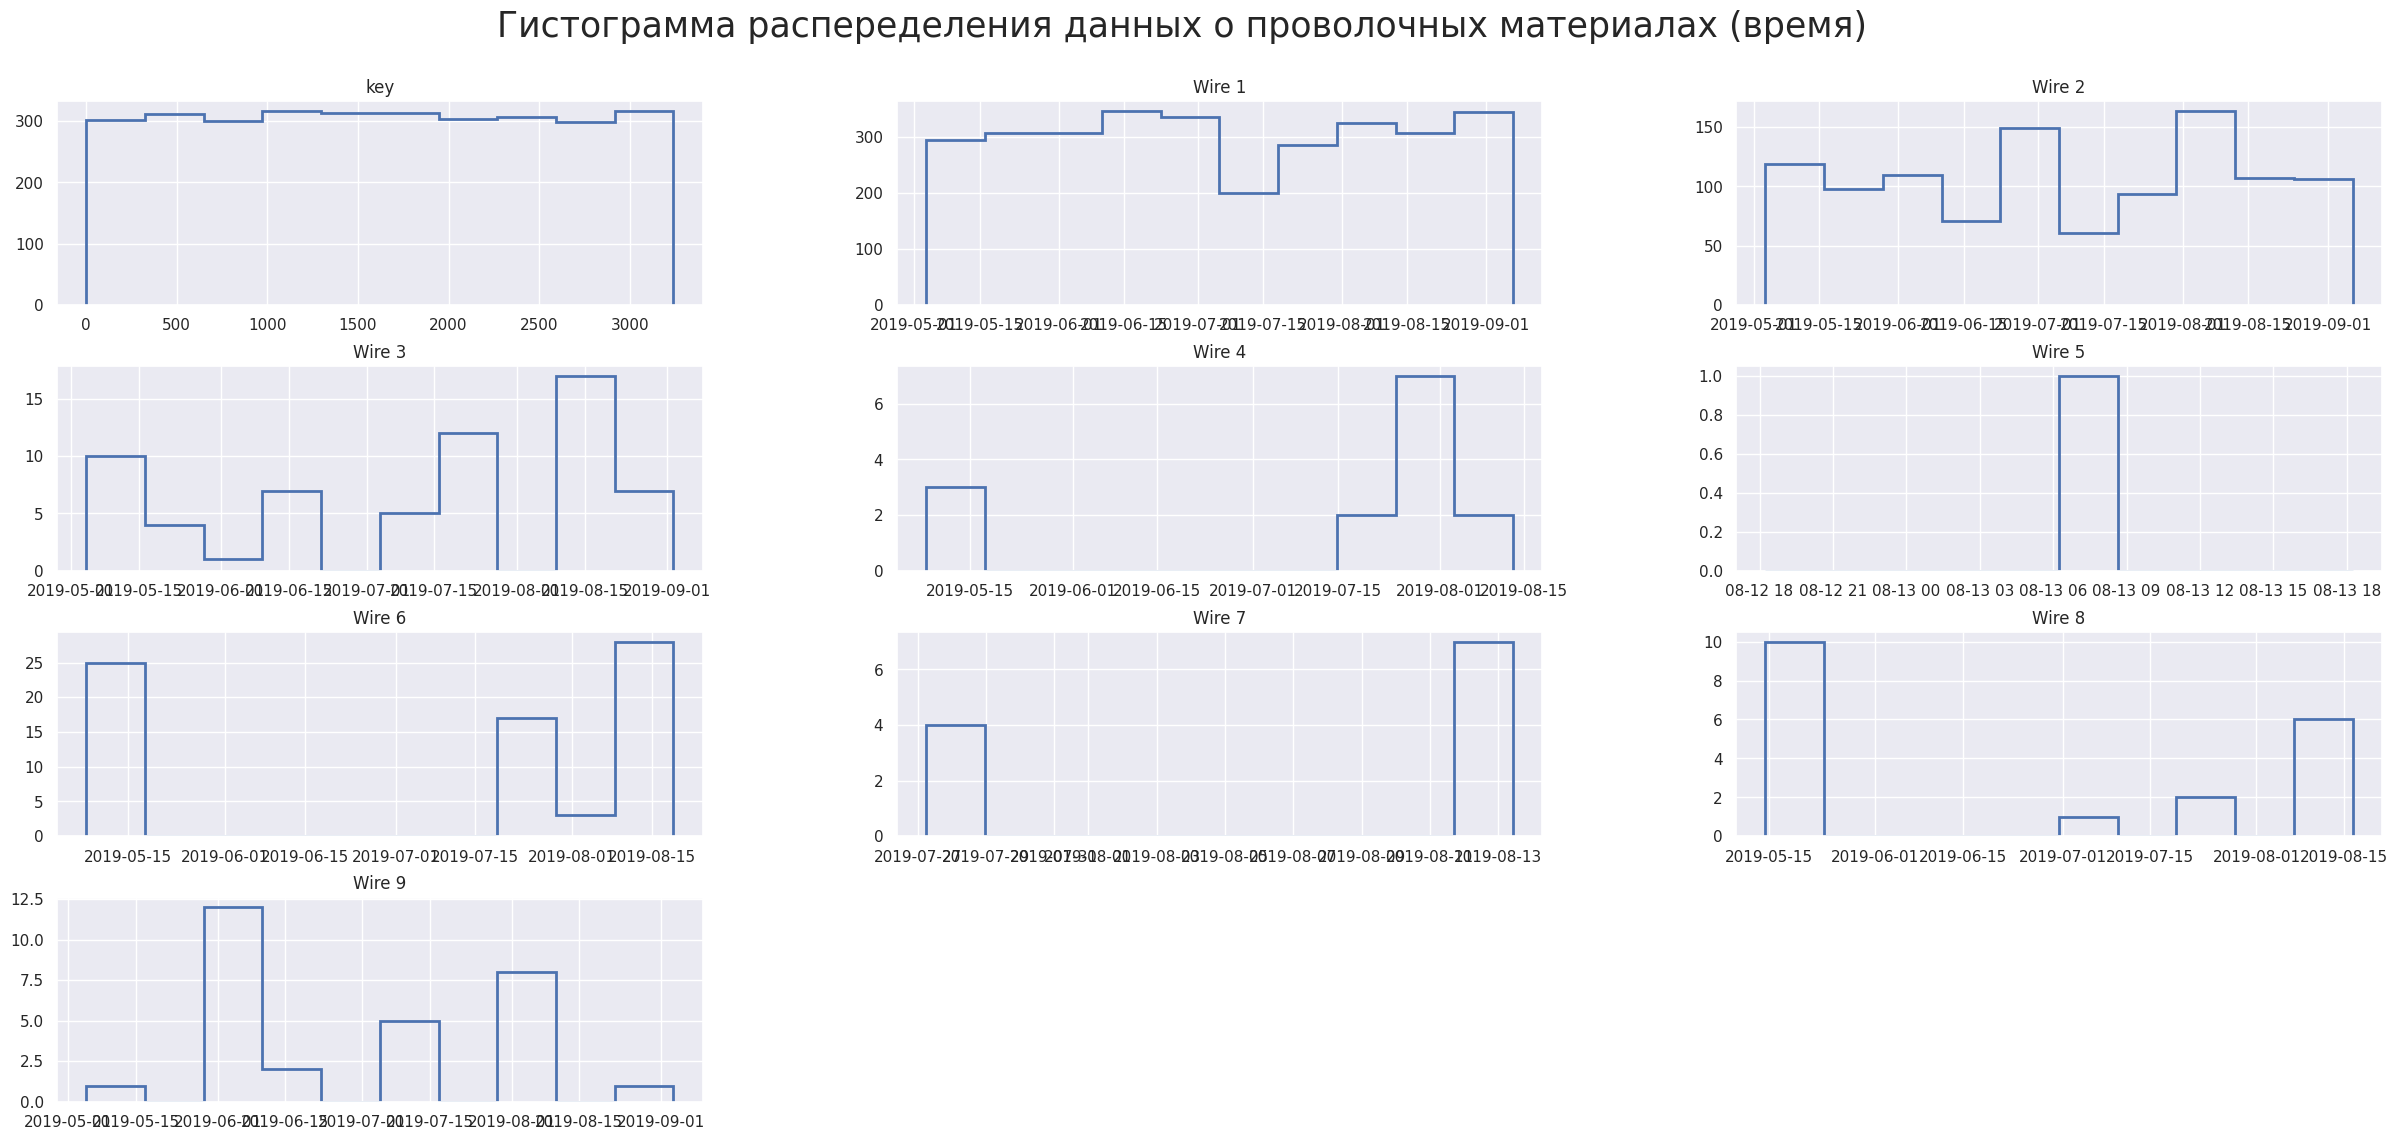


Корреляция данных о проволочных материалах (время)


,key
key,1.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
864,918,2019-06-08 00:14:44,2019-06-08 00:04:16,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1251,1320,2019-06-22 02:45:49,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2234,2345,2019-08-04 18:48:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1418,1490,2019-06-28 11:32:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2146,2256,2019-08-01 16:24:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


,key
count,"3,081.00"
mean,"1,623.43"
std,933.00
min,1.00
25%,823.00
50%,"1,619.00"
75%,"2,434.00"
max,"3,241.00"


In [ ]:
research(wire_t, 'данных о проволочных материалах (время)', figsize=(30,13), silent=False)

**Выводы:**
- Столбцы на разных языках. Имена столбцов нужно превести к общепринятому виду (английским языком, прописными буквами и без пробелов).
- стобцы с датами надо перевела сразу в соответствующий тип
-Данные выявляют возможный простой в июле месяце
- **Анализ данных мощностей показал**:
  - явных дубликатов и пропусков нет;
  - Распределение активной мощности похоже на нормальное распределение Пуассона со смещением влево. Среднее — 0.66, стандартное отклонение — 0.27
  - определили явный выброс в данных по Реактивной мощности, сразу удалила - мощность не моет быть меньше нуля. Данные сразу улучшились:
    > получившееся распределение Реактивной мощности также похоже на нормальное Пуассона со смещением влево, где среднее — 0.49, стандартное отклонение — 0.20
  -Явно наблюдается отсутствие работы электродов в июле месяце - возможно был технический сбой
- **Данные о продувке сплава газом**
  - Явных дубликатов и пропусков не наблюдается.
  - Распределение данных о продувке сплава газом - нормальное со смещением влево
- **Результаты измерения температуры:**
  - в столбце Температура 19% пропущенных данных - поработаем с этим
  - распределение данных нормальное
  - также наблюдается некий простой в работе в июле месяце (что соответствует данным работы электродов)
  - так как температура плавления стали 1450-1520°С, поэтому в нашем датасете считаем температуру ниже 1450 - выбросом - в дальнейшем удалим.
  - нетипичных выбросов более высоких температур не наблюдается, так как температура плавления некоторых тугоплавких металлов и сплавов может превышать 1600 градусов (видимо их используют не так часто): Титан (+1680°С), Платина (+1769,3°С), Хром (+1907°С). .
    > Поскольку мы не имеем точных данных по химсоставу используемых материаов, допускаю, что выбросы по температуре могут быть реальными измерениями расплавов тугоплавких сталей. Поэтому ничего не удаляю.

- **Анализ данных по сыпучим материалам показал:**
  - Отсутствуют дубликаты
  - Множество пропусков и по объему и по времени.
    >  Вероятнее всего обусловлено спецификой технологического процесса. Поэтому заменим пустые значения на 0
  - Нормальное распределение характерно для Bulk_4 и Bulk_6. Для Bulk_3 и Bulk_5 характерно нормальное распределение со сдвигом влево.
  Для остальных характерны доминанты определенных значений с характерными пиками на графиках распределения.
  - Сыпучие материалы добавляются в разных объемах:
    - меньше всего в среднем добавляют Bulk 1,
    - больше всего в среднем - Bulk 7.
    - чаще всего добавляют Bulk 14,
    - только 1 раз добавили Bulk 8.
  > То есть разные сыпучие материалы (легирующие добавки) по-разному действуют на металл, а Bulk 8 либо крайне редко использующаяся легирующая добавка, либо крайне дорогая, либо и то, и то.
- **Анализ данных по проволочным материалам выявил:**
  - Много пропущенных данных, вероятно не все данные фиксировались.
  - Видим отсутствие данных в столбцах Wire 4, Wire 5, Wire 7 - подумаем об их удалении его, для нас он неинформативен
  - практически полностью заполнены данные о о проволочных материалах в Wire 4. Пропуски только в 1%. Будем брать их за основу для формирования сводной таблицы.
   - Характерное нормальное распределение имеют признаки Wire 1, Wire 2, Wire 6. Остальные фичи имеют эпизодические пики.





## **2. Предобработка данных**

### **1. Приведение данных в нужный формат**

**Приведение к единому стилю названий столбцов**

In [ ]:
#приведу к нижнему регистру и в более читаемый стиль snake_case
#data.columns = map(str.lower, data.columns)
def name_colums(data):
  data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
  data.columns = data.columns.str.replace('ey', 'key')
  return data.columns
#bulk.columns

In [ ]:
#приведу к нижнему регистру и в более читаемый стиль snake_case
arc.columns = ['key', 'time_start','time_end', 'P', 'Q']
temp.columns = ['key', 'time_mesure','temp']
gas.columns = ['key', 'gas_1']
arc.columns

Index(['key', 'time_start', 'time_end', 'P', 'Q'], dtype='object')

In [ ]:
bulk.columns = name_colums(bulk)
bulk_t.columns = name_colums(bulk_t)
wire.columns = name_colums(wire)
wire_t.columns=name_colums(wire_t)
bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

### **2. Удаление дубликатов и обработка пропусков**

**Приводим в порядок датасет с температурой**

In [ ]:
#выведем информацию о пропусках с температурой
key_nan = temp[temp['temp'].isna()]['key'].unique()
temp[temp['temp'].isna()]

,key,time_mesure,temp
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [ ]:
#так как у key > 2499 отсутсвуют данные по температурам, удалим пропуски по всем связанным датасетам
temp =  temp.query('key < 2500')
temp[temp['temp'].isna()]['key'].unique()

array([], dtype=int64)

**Данные сыпучих и проволочных материалов**

In [ ]:
#проверим еще раз наличие пропусков в датасете 'wire' и 'wire_t'
print(round(wire.isna().sum()).sort_values(ascending=False).head(3))
wire.shape

wire_5    3080
wire_7    3070
wire_4    3067
dtype: int64


(3081, 10)

In [ ]:
#проверим еще раз наличие пропусков в датасете 'wire'
print(round(wire_t.isna().sum()).sort_values(ascending=False).head(3))
wire_t.shape

wire_5    3080
wire_7    3070
wire_4    3067
dtype: int64


(3081, 10)

In [ ]:
def info_nan (data, name):
    data_nul=data.loc[~data[f'{name}'].isna()]
    display(data_nul)

In [ ]:
#удаляем wire_5 - так как там данные практически отсутствуют
wire = wire.drop('wire_5',axis=1)
wire_t = wire_t.drop('wire_5',axis=1)
#wire.columns
wire_t.shape

(3081, 9)

In [ ]:
#заполним пропущенные значения 0 в датасетах с сыпучими и проволочными материалами
def fill(data, fill_data):
    data_filled = data.fillna(fill_data)
    return data_filled

In [ ]:
wire = fill(wire, 0)
wire_t = fill(wire_t, 0)
bulk = fill(bulk, 0)
bulk_t = fill(bulk_t, 0)
bulk.isna().sum().sum()

0

**Вывод:**
- Удалила пропуски в датасете temp
- Удалила столбец wire_5 в wire_t и wire, так как там практически отсутствуют данные
- Заполнила пропуски 0 в датасетах с сыпучими и проволочными материалами

### **3. Удаление аномалий**

In [ ]:
#функция удаления аномалий и выбросов по всем датасетам
def anomaly (data, key_data):
    #display(data.loc[data['key']==key_data[0]].tail(1))  #текущее состояние
    for key in key_data:
        data=data.loc[data['key']!=key]
    #display(data.loc[data['key']==key_data[0]].head(1))  #результат итераций
    return data

**Данные об электродах**

In [ ]:
#удалим аномалии мощности по всему дата сету
key_minor = arc[arc['Q'] < 0]['key'].tolist()  #unique
arc[arc['Q']<0]

,key,time_start,time_end,P,Q
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.71,-715.48


In [ ]:
arc = anomaly(arc, key_minor)
arc[arc['Q']<0]

,key,time_start,time_end,P,Q


**Температура**

In [ ]:
#строки с партиями, где температура < 1500
key_1500 = temp[temp['temp'] <= 1500]['key'].tolist()
key_1500

[867, 1214, 1619, 2052]

In [ ]:
#Считаем t<1500 град, выбросом - удаляем эти данные по всем партиям
temp = anomaly(temp, key_1500)
temp.tail()

,key,time_mesure,temp
13921,2499,2019-08-10 13:33:21,"1,569.00"
13922,2499,2019-08-10 13:41:34,"1,604.00"
13923,2499,2019-08-10 13:46:28,"1,593.00"
13924,2499,2019-08-10 13:54:56,"1,588.00"
13925,2499,2019-08-10 13:58:58,"1,603.00"


In [ ]:
count = temp.groupby(by = 'key', as_index=False).count()
bad_keys = count[count['time_mesure']== 1]['key'].tolist()
print(f'ключи с плохим замерами температуры: {bad_keys}, длина списка с ключами: {len(bad_keys)}')

ключи с плохим замерами температуры: [195, 279], длина списка с ключами: 2


In [ ]:
#Нашла и сформировала список начальной и конечной температуры замера
temp = temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
temp.columns = temp.columns.droplevel()
temp.columns = ['key', 'mesure_1', 'mesure_2', 'temp_1', 'temp_2']
temp.tail(3)

,key,mesure_1,mesure_2,temp_1,temp_2
2470,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,"1,571.00","1,589.00"
2471,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,"1,591.00","1,594.00"
2472,2499,2019-08-10 13:33:21,2019-08-10 13:58:58,"1,569.00","1,603.00"


Вывод:
- Удалила аномалии по температуре и по данным электродов
- Нашла ключи по аномаличм, чтобы применить их для очистки оставшихся датасетов - в данном случае для проверки
- Данные найденых выбросов в других датасетах в процессе формирования итогового датасета методом inner join

### **5. Подготовка общего датасета. Генерация ряда признаков**

In [ ]:
print('Корреляция Активной и Реактивной мощностей', arc['P'].corr(arc['Q']))

Корреляция Активной и Реактивной мощностей 0.9663821708188474


 - Корреляция между активоной и реактивной мощностей corr=0.97, значит велика вероятность того, что модель может переобучиться - поэтому в качестве признака лучше использовать полную мощность:
   > применим формулу:
 $$
 S = (P^{2}+Q^{2})^{1/2},
 $$
где: *P* — активная мощность, *Q* — реактивная мощность
- также введем понятие общей работы при нагреве электродов
$$
 A_t = S*(t_2-t_1)
$$

In [ ]:
#время нагрева дугой в сек
arc['delta_time'] = (arc['time_end'] - arc['time_start']).dt.seconds #// pd.Timedelta('1s')

In [ ]:
#Создадим датасет, сгруппируем по key и агрегируем мощности по сумме итераций
arc_sum = arc.groupby(by = 'key', as_index=False).sum()
arc_sum.head(3)

,key,P,Q,delta_time
0,1,3.04,2.14,1098
1,2,2.14,1.45,811
2,3,4.06,2.94,655


In [ ]:
#сформируем итоговую таблицу с целевым признаком temp_2
temp_final = temp[['key', 'temp_1', 'temp_2']]
temp_final.tail(3)

,key,temp_1,temp_2
2470,2497,"1,571.00","1,589.00"
2471,2498,"1,591.00","1,594.00"
2472,2499,"1,569.00","1,603.00"


In [ ]:
#Сформируем новые признаки
#полная мощность
arc_sum['S'] = np.sqrt(arc_sum['P']**2 + arc_sum['Q']**2)
#Работа производимая эдектродами
arc_sum['A_total'] = arc_sum['S'] * arc_sum['delta_time']
# количество итераций
arc_iter = arc['key'].value_counts().sort_index().sort_index().reset_index()
arc_iter = arc_iter.rename(columns={'index': 'key', 'key' : 'heat_iter'})
#arc_iter
arc_sum = arc_sum.merge(arc_iter, how='left', on='key')
arc_sum.head(3) #.reset_index()

,key,P,Q,delta_time,S,A_total,heat_iter
0,1,3.04,2.14,1098,3.72,"4,080.87",5
1,2,2.14,1.45,811,2.59,"2,097.55",4
2,3,4.06,2.94,655,5.01,"3,284.28",5


Так как вводим прзнак А - работа, то в будущем имеет смысл удалить другие признаки (P,Q,S), чтобы избежать утечки.

In [ ]:
data_arc=arc_sum.copy()

In [ ]:
data = (arc_sum.merge(temp_final, how='inner', on='key')
                .merge(wire, how='inner', on='key')
                .merge(bulk, how='inner', on='key')
                .merge(gas, how='inner', on='key'))
print(data.shape)
data.columns

(2324, 33)


Index(['key', 'P', 'Q', 'delta_time', 'S', 'A_total', 'heat_iter', 'temp_1',
       'temp_2', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
       'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'gas_1'],
      dtype='object')

In [ ]:
#провелим удалились ли данные с выбросами по всем датасетам
display(data.loc[data['key']==bad_keys[0]].tail(1))
#display(data.loc[data['key']==key_minor[0]].tail(1))

,key,P,Q,delta_time,S,A_total,heat_iter,temp_1,temp_2,wire_1,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1


In [ ]:
#Переведем некоторые даннные в int
data['temp_1'] = pd.to_numeric(data['temp_1'], downcast='integer')
data['temp_2'] = pd.to_numeric(data['temp_2'], downcast='integer')
for i in range(1,16):
    data[f'bulk_{i}'] = pd.to_numeric(data[f'bulk_{i}'], downcast='integer')
#data.info()

### **6. Исследование итогового датафрейма (в том числе графически)**
- Исследование на взаимную кореляцию
- Исследование на кореляцию c целевым признаком

In [ ]:
#напишем функию для исследования данных
def research1(data, name, figsize, silent):
    print(f'Размер данных:      {data.shape}')
    if silent:
        data.columns
    if not silent:
        print(f'Количество явных дубликатов: {data.duplicated().sum()}')
        print(f'Наличие пропусков:           {data.isna().sum().sum()}')
        data.info()

    if silent:
        data.columns
    #тепловая карта корреляций
    phik_overview = data.phik_matrix()
    plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Pastel2", #Greens
                        title=f"Корреляция {name} $\phi_K$", #r"Корреляция {name} $\phi_K$"
                        fontsize_factor=1.5,
                        figsize=(25, 20))
    plt.tight_layout()
    if not silent:
        #print(f'\nПроверка структуры {name}:')
        data.hist(linewidth=2, histtype='step', figsize=figsize) #
        plt.suptitle(f'Гистограмма распеределения {name}', y=0.91, fontsize=25)
        plt.show()
        print()
        display(data.sample(3))
        display(data.describe())

Размер данных:      (2324, 33)
Количество явных дубликатов: 0
Наличие пропусков:           0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2324 non-null   int64  
 1   P           2324 non-null   float64
 2   Q           2324 non-null   float64
 3   delta_time  2324 non-null   int64  
 4   S           2324 non-null   float64
 5   A_total     2324 non-null   float64
 6   heat_iter   2324 non-null   int64  
 7   temp_1      2324 non-null   int16  
 8   temp_2      2324 non-null   int16  
 9   wire_1      2324 non-null   float64
 10  wire_2      2324 non-null   float64
 11  wire_3      2324 non-null   float64
 12  wire_4      2324 non-null   float64
 13  wire_6      2324 non-null   float64
 14  wire_7      2324 non-null   float64
 15  wire_8      2324 non-null   float64
 16  wire_9      2324 non-null   float64
 17  bulk_1      2324

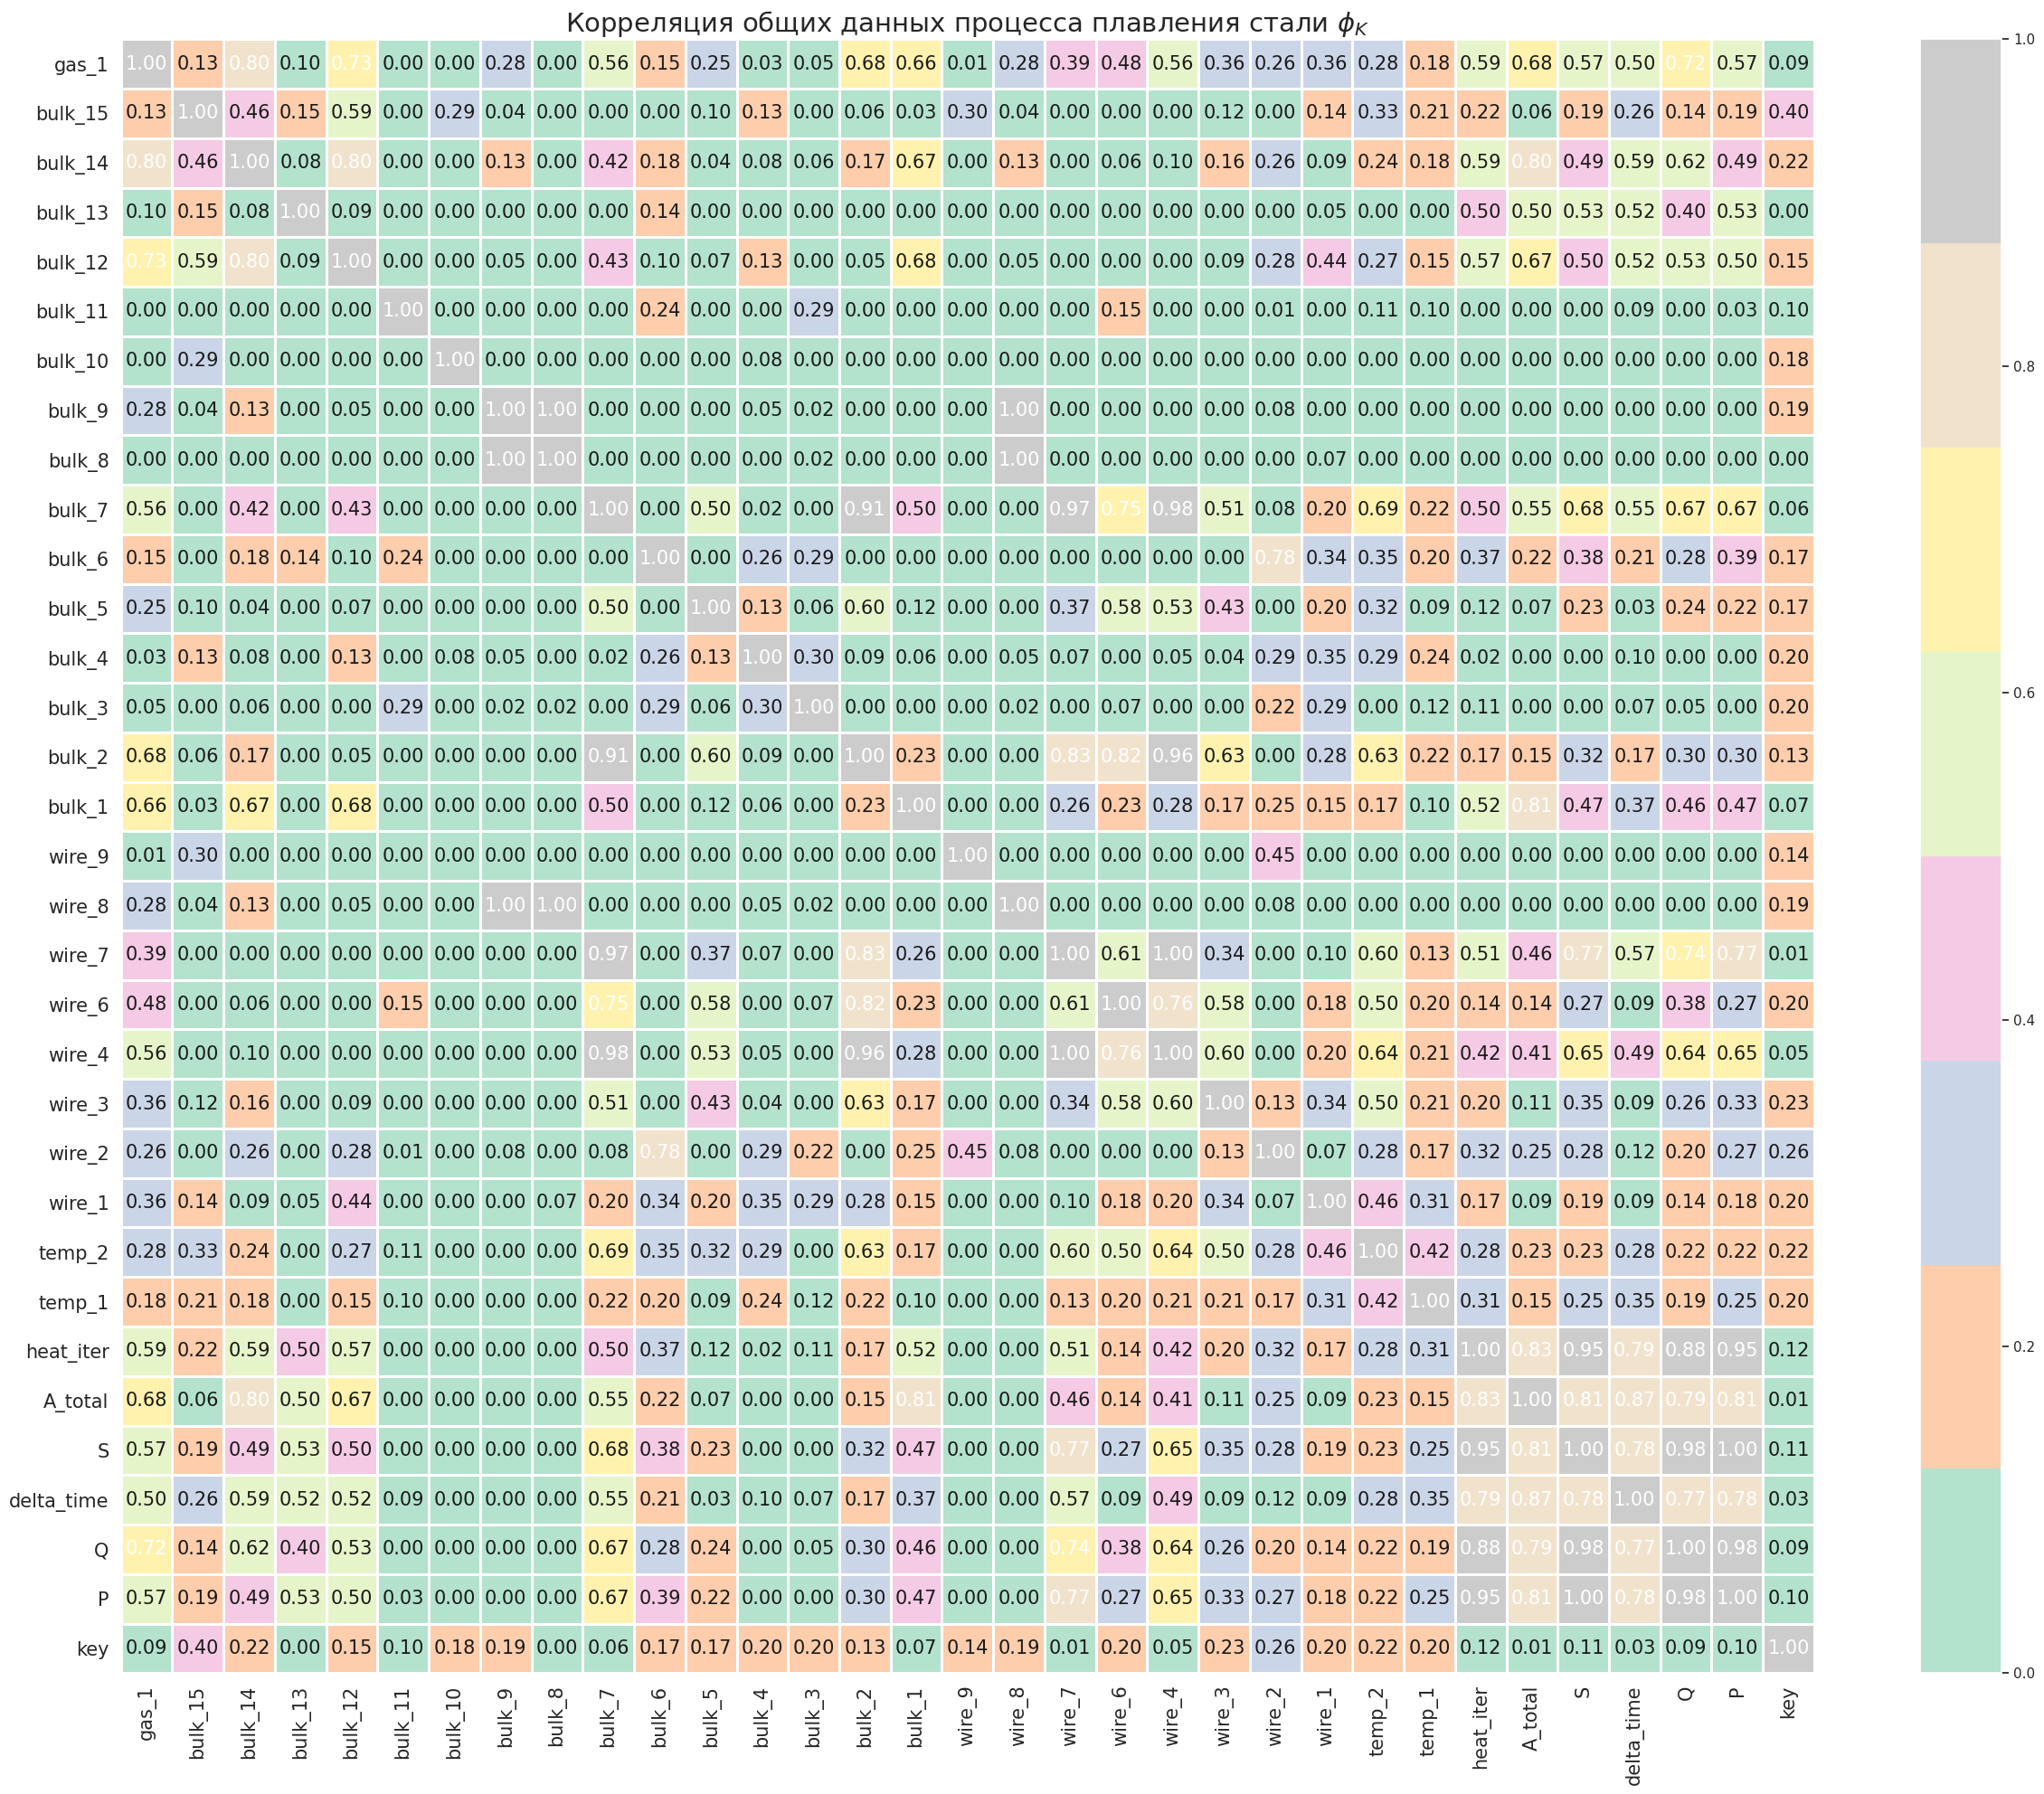

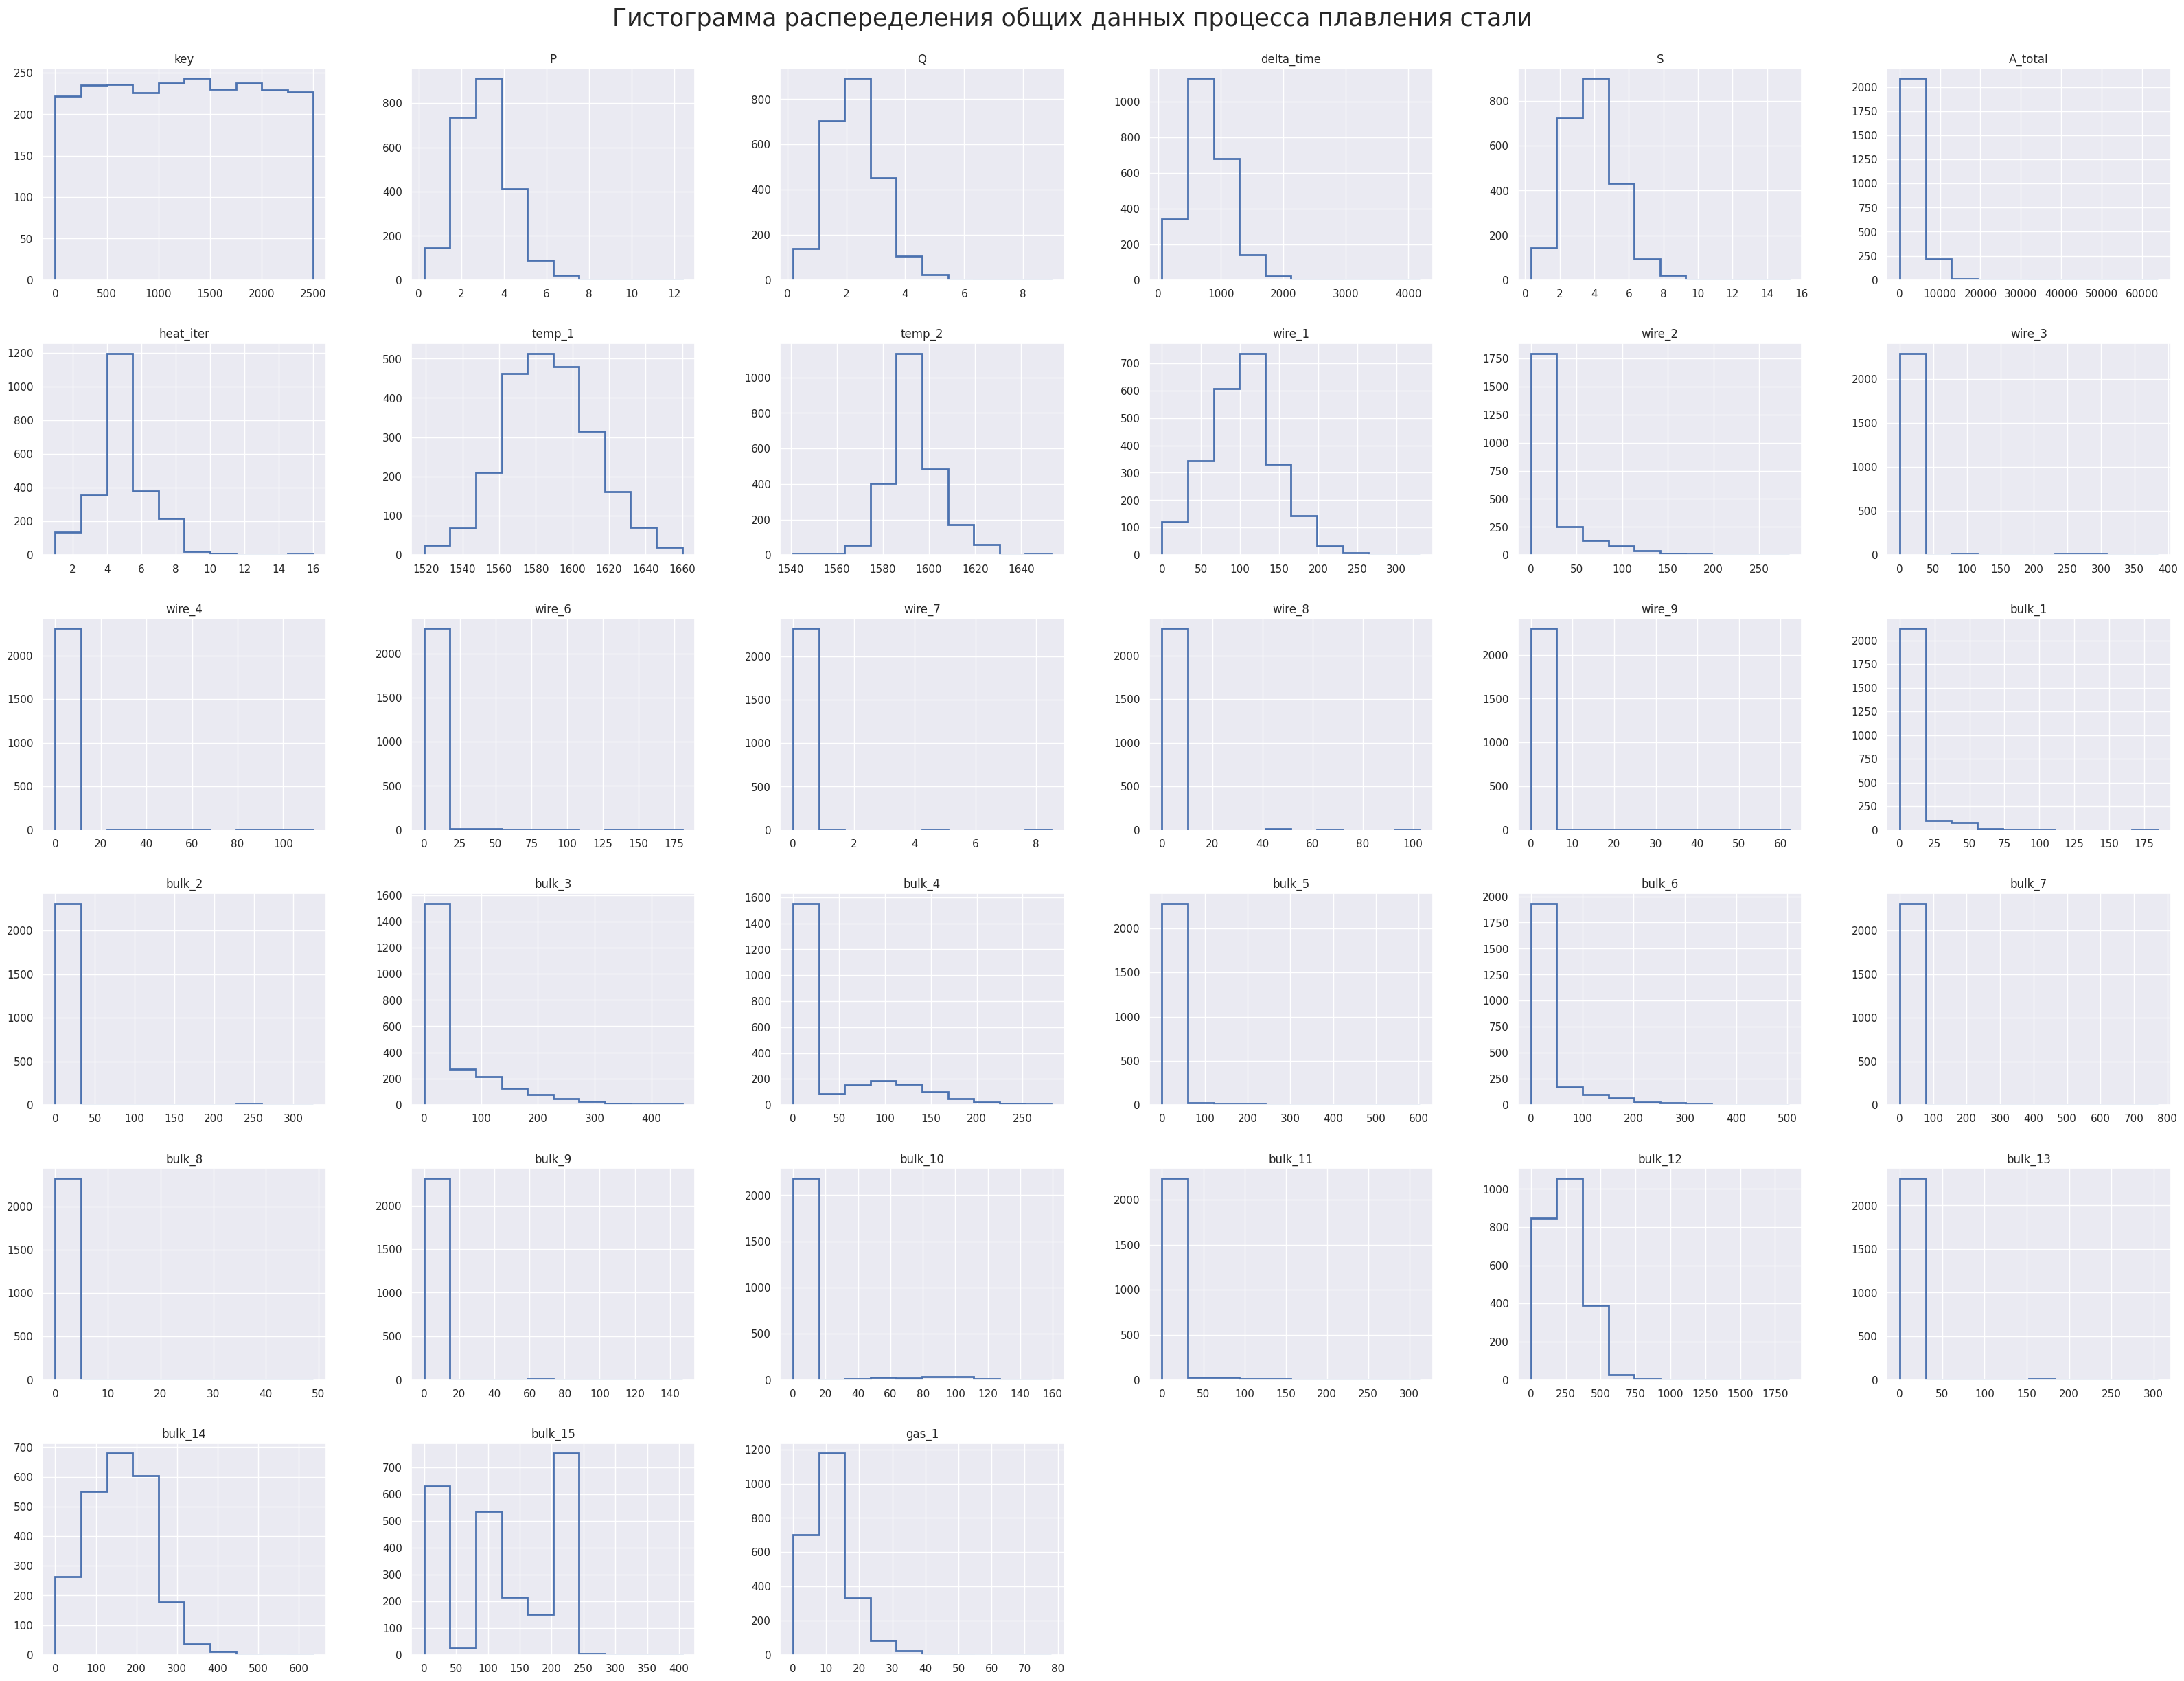

,key,P,Q,delta_time,S,A_total,heat_iter,temp_1,temp_2,wire_1,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
1121,1212,1.55,1.04,760,1.87,"1,417.52",3,1570,1590,93.97,...,0,0,0,0,0,411,0,208,206,6.08
601,649,3.70,2.77,1196,4.62,"5,528.33",6,1552,1581,90.18,...,0,0,0,0,0,206,0,152,203,5.01
2100,2253,4.41,3.51,903,5.63,"5,084.31",5,1572,1590,81.16,...,0,0,0,0,0,211,0,149,208,9.63


,key,P,Q,delta_time,S,A_total,heat_iter,temp_1,temp_2,wire_1,...,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1
count,"2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00",...,"2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00","2,324.00"
mean,"1,251.14",3.13,2.30,808.20,3.88,"3,509.67",4.70,"1,587.37","1,593.37",102.42,...,2.01,0.02,0.45,5.06,4.25,208.60,1.07,153.95,120.08,11.38
std,715.03,1.22,0.90,340.81,1.52,"3,038.01",1.61,23.63,11.21,43.54,...,30.71,1.02,6.23,20.94,22.54,157.11,14.25,81.41,84.66,6.40
min,1.00,0.27,0.20,57.00,0.33,33.43,1.00,"1,519.00","1,541.00",0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
25%,628.75,2.30,1.67,581.00,2.84,"1,709.87",4.00,"1,571.00","1,587.00",73.20,...,0.00,0.00,0.00,0.00,0.00,105.00,0.00,105.00,0.00,7.28
50%,"1,254.50",3.04,2.23,778.00,3.77,"2,905.44",5.00,"1,587.00","1,593.00",101.10,...,0.00,0.00,0.00,0.00,0.00,206.00,0.00,149.00,107.00,10.10
75%,"1,867.25",3.83,2.83,993.00,4.77,"4,511.99",6.00,"1,603.00","1,598.00",128.08,...,0.00,0.00,0.00,0.00,0.00,283.00,0.00,204.00,204.00,14.22
max,"2,499.00",12.38,8.95,"4,189.00",15.27,"63,975.49",16.00,"1,660.00","1,653.00",330.31,...,772.00,49.00,147.00,159.00,313.00,"1,849.00",305.00,636.00,405.00,78.00


In [ ]:
research1(data, 'общих данных процесса плавления стали', figsize=(40,30), silent=False)

**Выводы:**
- Наблюдается сильная корреляция между такими признаками как 'P', 'Q', 'delta_time', 'S', 'A_total', 'heat_iter' - что в принципе объяснимо. Для этого и вводила признак Работы (которая объединила бы в одно данные об электродах). Поэтому оставляем одну работу $A_t$
- Также наблюдается большая корреляция (больше 80) между `bulk_9`, `bulk_8` и `wire_8`, а также `bulk_2`, `bulk_7`, `wire_7` и `wire_4` - оставляем по одному признаку.


In [ ]:
#удаляем данные с высокой корреляцией
data = data.drop([ 'key', 'P', 'Q', 'S', 'delta_time', 'wire_8', 'bulk_8', 'bulk_2','wire_7', 'wire_4', 'heat_iter'], axis=1)#'bulk_9', 'bulk_8',
data.columns

Index(['A_total', 'temp_1', 'temp_2', 'wire_1', 'wire_2', 'wire_3', 'wire_6',
       'wire_9', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'gas_1'],
      dtype='object')

Размер данных:      (2324, 22)
interval columns not set, guessing: ['A_total', 'temp_1', 'temp_2', 'wire_1', 'wire_2', 'wire_3', 'wire_6', 'wire_9', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas_1']


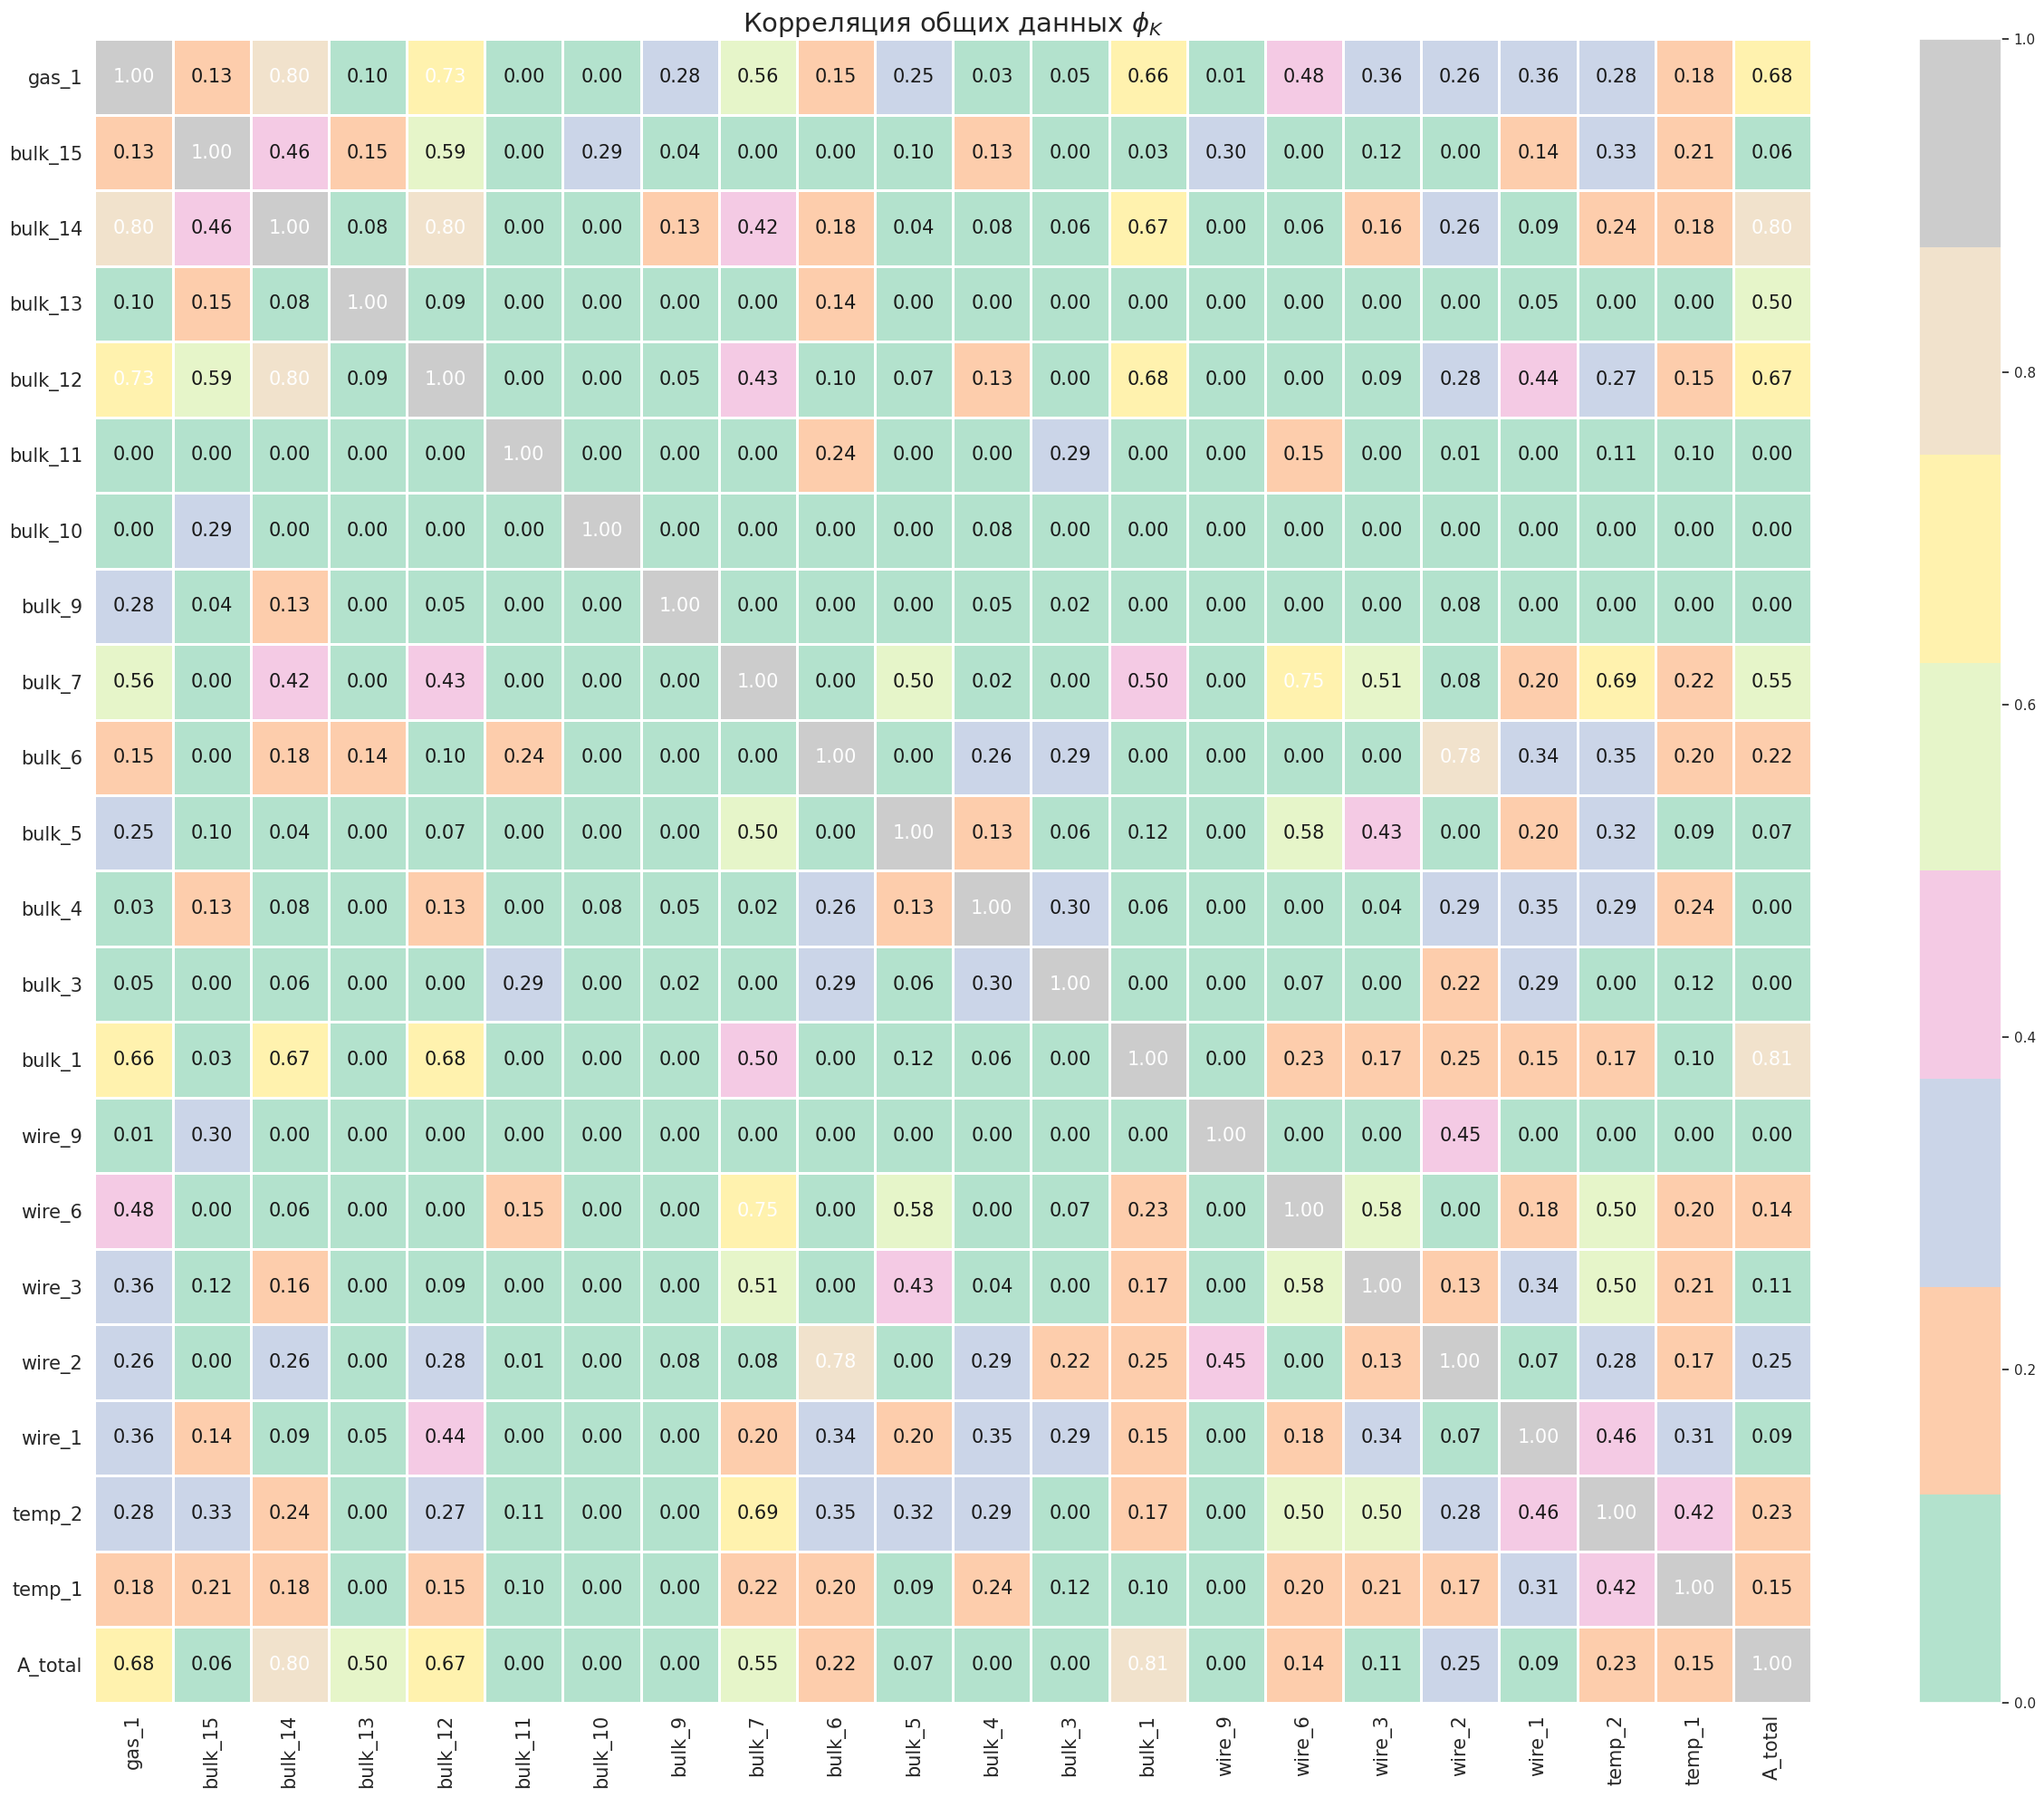

In [ ]:
research1(data, 'общих данных', figsize=(35,25), silent=True)

In [ ]:
#выделим признаки с корреляцией больше 0,8
#phik_overview = data.phik_matrix()
data.corr().unstack()[(data.corr().unstack() < 1) & (abs(data.corr().unstack()) > 0.8)].head(15)

Series([], dtype: float64)

- Удалим, пожалуй, признак о количестве итераций нагрева
- Начальная и конечная температуры также находятся в сильном взаимодействии

interval columns not set, guessing: ['A_total', 'temp_1', 'temp_2', 'wire_1', 'wire_2', 'wire_3', 'wire_6', 'wire_9', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas_1']


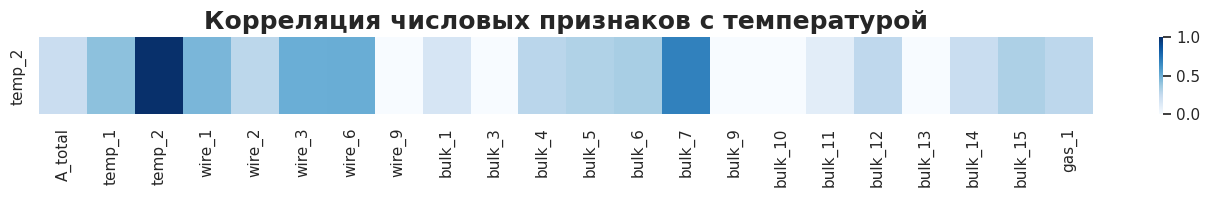

In [ ]:
#um=data.select_dtypes(exclude='object')
#numcorr=num.corr()
phik_overview = data.phik_matrix()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(phik_overview.sort_values(by=['temp_2'], ascending=False).head(1), cmap='Blues')
plt.title('Корреляция числовых признаков с температурой', weight='bold', fontsize=18)
plt.show()

In [ ]:
target_t2=pd.Series()
for i in data.columns:
    target_t2[i] = data['temp_2'].corr(data[i])
target_t2= target_t2.sort_values(ascending=False)[1:]
#target_t2

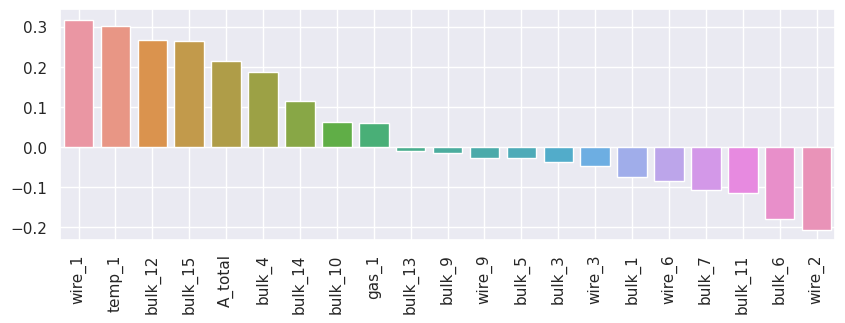

In [ ]:
plt.figure(figsize=(10,3))
sns.barplot(x=target_t2.index, y=target_t2.values)
plt.grid()
plt.xticks(rotation=90)
plt.show();

Сильная корреляция:
- Как видно по таблице, между собой коррелируют такие столбцы как: Активная и Реактивная мощность, Время нагрева дугой в сек, Полная мощность и Работа.

Их высокая корреляция может привести к переобучению моделей, так что их нужно убрать и оставить Работу:
- удаляем '`P`', '`Q`', '`delta_time`', '`time_start`', '`time_end`' и `A` - оставляем `A`
- `bulk_9`, `bulk_8` и `wire_8`, а также `bulk_2`, `bulk_7`, `wire_7` и `wire_4` - оставляем по одному.


**Выводы:**
- был подготовлен итоговый датасет:
добавдены некоторы
- проверен на корреляцию признаков между собой и с целевым признаком
- в качестве целевого признака взята конечная температура `temp_2`
- наблюдается незначительная корреляция с оставшимися признаками, наиболее сильная с `wire 1`, `bulk_14` и `bulk_15` (а при применении `phik` `wire_7 и bulk_7`).

### **7. Разбивка данных на тренировочные и тестовые в масштабе 1:4**


In [ ]:
#входящие данные
random_state = 80523
cv_counts = 5
features = data.drop('temp_2', axis=1)
target = data['temp_2']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, target,
                                                            test_size=0.25, random_state=random_state)
#Проверим размеры выборок:
for i in [features_train, target_train, features_test, target_test]:
    print(i.shape)

(1743, 21)
(1743,)
(581, 21)
(581,)


### **8. Масштабирование признаков - стандартизация данных, при необходимости**

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)
# стандартизируем данные трейна
features_train_scale = scaler.transform(features_train)
features_train_scale = pd.DataFrame(features_train_scale, columns = features_train.columns)
# стандартизируем данные на тестовой выборке
features_test_scale = scaler.transform(features_test)
features_test_scale = pd.DataFrame(features_test_scale, columns = features_test.columns)
print(f'размер обучающей выборки: {features_train_scale.shape}')
print(f'размер тестовой выборки: {features_test_scale.shape}')

размер обучающей выборки: (1743, 21)
размер тестовой выборки: (581, 21)


In [ ]:
def st_scaler(features, features_train):
    # создадим и обучим объект
    scaler = StandardScaler()
    scaler.fit(features_train)
    # стандартизируем данные и реализуем обновленный датафрейм
    features_scale = scaler.transform(features)
    features_scale = pd.DataFrame(features_scale, columns = features.columns)
    return features_scale

In [ ]:
features_train_scale = st_scaler(features_train, features_train)
features_test_scale = st_scaler(features_test, features_train)
print(f'размер обучающей выборки: {features_train_scale.shape}')
print(f'размер тестовой выборки: {features_test_scale.shape}')

размер обучающей выборки: (1743, 21)
размер тестовой выборки: (581, 21)


## **3. Построение моделей**
- Модель **Линейной регрессии**
- Модель **Случайного леса**
- Модель **CatBoost**
- Модель **LGBMRegressor**
- Модель **XGBRegressor** (по возможности)

### **1.Перекрестная проверка данных**
Функция принимает в качестве входных данных следующие параметры:
 - `random_state = 80523`
 - `cv_counts = 5`

In [ ]:
%%time
# Сравним алгоритмы выборочной проверки
from sklearn.model_selection import TimeSeriesSplit
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor(random_state = random_state))) #, n_estimators = 10
models.append(('CatBoostR', CatBoostRegressor(random_state = random_state, verbose=False)))
models.append(('LGBMR', LGBMRegressor(random_state = random_state)))
models.append(('XGBR', XGBRegressor(random_state = random_state)))

# запускаем расчет моделей в цикле
results = []
names = []
for name, model in models:
    cv_mae = (cross_val_score(model,
                             features_train_scale,
                             target_train,
                             cv=cv_counts,
                             scoring='neg_mean_absolute_error').mean() * -1)
    results.append(cv_mae)
    names.append(name)
    print('MAE %s:  %f ' % (name, cv_mae.mean()))#(%f), cv_mae.std()

MAE LR:  6.860780 
MAE RF:  6.699693 
MAE CatBoostR:  6.595735 
MAE LGBMR:  6.836586 
MAE XGBR:  7.205590 
CPU times: user 47.8 s, sys: 1.69 s, total: 49.5 s
Wall time: 40.6 s


In [ ]:
results_cv = pd.DataFrame(results, index = names, columns = ['mae_cv'] )
results_cv

,mae_cv
LR,6.86
RF,6.70
CatBoostR,6.60
LGBMR,6.84
XGBR,7.21


**Вывод:**
- Предварительный анализ моделей на кросс-валидации показал, что лучше всего себя ведет **CatBoostRegressor**:
 - **MAE_LR=6.60**

### **2. Проверка модели на адекватность с помощью константной модели**

In [ ]:
for strategy in ['mean', 'median']:
    dummy = DummyRegressor(strategy=strategy)
    dummy.fit(features_train_scale, target_train)
    predict = dummy.predict(features_test)
    mae_dummy = mean_absolute_error(target_test, predict)
    print(f'Итоговая оценка на константной модели : MAE_{strategy} = {mae_dummy}')

Итоговая оценка на константной модели : MAE_mean = 8.052636412381768
Итоговая оценка на константной модели : MAE_median = 8.029259896729776


### **3. Обучение и подбор параметров моделей. Выбор лучшей**

Проведем обучение моделей и подбор гиперпараметров методами **RandomizedSearchCV** и **GridSearchCV**

In [ ]:
# Вводим переменные
model_1 = LinearRegression()
model_2 = RandomForestRegressor(random_state = random_state)
model_3 = CatBoostRegressor(random_state = random_state, verbose=False)
model_4 = LGBMRegressor(random_state = random_state)
model_5 = XGBRegressor(random_state = random_state)

In [ ]:
%%time
# Инициируем гиперпараметры для рассматриваемых моделях
param1 = {}
param1['regression__fit_intercept'] = [True, False]
param1['regression'] = [model_1]

param2 = {}
param2['regression__n_estimators'] = [10, 50, 100, 250]
param2['regression__max_depth'] = [5, 10, 20]
param2['regression__max_features'] = ['auto', 'sqrt', 'log2']
#param2['regression__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['regression'] = [model_2]

param3 = {}
param3['regression__learning_rate'] = [i/10 for i in range(1, 6)]
param3['regression__n_estimators'] = [50, 100, 10]
param3['regression__loss_function'] = ['MAE']
param3['regression__max_depth'] = [i for i in range(5,10)]
#param3['regression__class_weight'] = [None, 'balanced']
param3['regression'] = [model_3]

param4 = {}
param4['regression__learning_rate'] = [i/10 for i in range(1, 6)]
param4['regression__n_estimators'] = [10, 50, 100, 250]
param4['regression__max_depth'] = [i for i in range(5,15)]
param4['regression__boosting_type'] = ['gbdt']
param4['regression'] = [model_4]

param5 = {}
param5['regression__learning_rate'] = [i/100 for i in range(1, 50)]
param5['regression__silent'] = [True]
param5['regression'] = [model_5]

CPU times: user 0 ns, sys: 29 µs, total: 29 µs
Wall time: 33.1 µs


In [ ]:
%%time
pipeline = Pipeline([('regression', model_1)])
params = [param1, param2, param3, param4, param5]

CPU times: user 51 µs, sys: 0 ns, total: 51 µs
Wall time: 55.1 µs


### GridSearchCV

In [ ]:
%%time
start = time.time()
gs = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error').fit(features_train_scale, target_train)
end = time.time()
t_gs=round(end-start,2)

CPU times: user 7.28 s, sys: 503 ms, total: 7.78 s
Wall time: 7min 37s


In [ ]:
# Гиперпараметры лучшей модели на GridSearchCV
gs.best_params_

{'regression': <catboost.core.CatBoostRegressor at 0x7fae804d4eb0>,
 'regression__learning_rate': 0.1,
 'regression__loss_function': 'MAE',
 'regression__max_depth': 5,
 'regression__n_estimators': 100}

In [ ]:
# MAE для лучшей модели
mae_gs = gs.best_score_
print(f'Абсолютное среднее отклонение лучшей модели, найденной методом GridSCV MAE_train = {round(mae_gs.mean() * -1, 2)}')

Абсолютное среднее отклонение лучшей модели, найденной методом GridSCV MAE_train = 6.53


### Randomized Search CV

In [ ]:
%%time
start = time.time()
rs = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error').fit(features_train_scale, target_train)
end = time.time()
t_rs=round(end-start,2)

CPU times: user 186 ms, sys: 9.07 ms, total: 196 ms
Wall time: 4 s


In [ ]:
# Гиперпараметры лучшей модели на RandomizedSearchCV
rs.best_params_

{'regression__n_estimators': 50,
 'regression__max_depth': 5,
 'regression__learning_rate': 0.1,
 'regression__boosting_type': 'gbdt',
 'regression': LGBMRegressor(max_depth=5, n_estimators=50, random_state=80523)}

In [ ]:
# MAE для лучшей модели
mae_rs = rs.best_score_
print(f'Абсолютное среднее отклонение лучшей модели, найденной методом RandomSCV MAE_train = {round(mae_rs.mean() * -1, 2)}')

Абсолютное среднее отклонение лучшей модели, найденной методом RandomSCV MAE_train = 6.66


In [ ]:
%%time
start = time.time()
# лучшая модель от randomsearchCV на чистых данных
rs_cl = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error').fit(features_train, target_train)
end = time.time()
t_rs=round(end-start,2)

CPU times: user 348 ms, sys: 16 ms, total: 364 ms
Wall time: 8.33 s


In [ ]:
# MAE модель randomsearchCV на чистых данных
mae_rs_cl = rs_cl.best_score_
print(f'Абсолютное среднее отклонение лучшей модели на чистых данных, найденной методом RandomSCV MAE_train = {round(mae_rs_cl.mean() * -1, 2)}')

Абсолютное среднее отклонение лучшей модели на чистых данных, найденной методом RandomSCV MAE_train = 6.8


### **4. Проверка лучшей модели на тестовой выборке.**
Исследование значимости признаков лучшей модели.

In [ ]:
# Проверяю лучшую модель, найденную через **GridSearchCV** на тестовой выборке
mae_test_gs = mean_absolute_error(gs.predict(features_test_scale), target_test)
print(f'Абсолютное среднее отклонение лучшей модели, найденной методом GridSearchCV MAE_test = {round(mae_test_gs,2)}')

Абсолютное среднее отклонение лучшей модели, найденной методом GridSearchCV MAE_test = 6.39


In [ ]:
index = names
data = {'mae_cv': results,
        'mae_GrinSCV':['None', 'None', round(mae_gs.mean() * -1, 2), 'None','None'],
        'mae_RandomSCV':['None', 'None', round(mae_rs.mean() * -1, 2), 'None','None'],
        'mae_test_GrinSCV':['None', 'None', round(mae_test_gs,2), 'None','None'],
        'mae_test_RandomSCV':['None', 'None', round(mae_test_gs, 2), 'None','None']}

results_cv = pd.DataFrame(data=data, index=index)
#results_cv['Выполнение задачи'] = results_cv['mae_test_RandomSCV'] <= 6.8
results_cv

,mae_cv,mae_GrinSCV,mae_RandomSCV,mae_test_GrinSCV,mae_test_RandomSCV
LR,6.86,None,None,None,None
RF,6.70,None,None,None,None
CatBoostR,6.60,6.53,6.66,6.39,6.39
LGBMR,6.84,None,None,None,None
XGBR,7.21,None,None,None,None


### **5. Исследование значимости признаков лучшей модели**



In [ ]:
%%time
#найдем признаки лучшей модели полученной методом GridSCV
start = time.time()
#gs_importances = gs.fit(features_train_scale, target_train)
feature_importances_gs = gs.best_estimator_._final_estimator.feature_importances_
feature_importances_gs
end = time.time()
t_rs=round(end-start,2)

CPU times: user 457 µs, sys: 0 ns, total: 457 µs
Wall time: 464 µs


In [ ]:
# визуализируем важность признаков
def graph_features (model, features, name):
    feature_importance = pd.DataFrame((model), list(features.columns),columns=['Значения'])\
                                        .reset_index().rename(columns={'index':'Признаки'})
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Значения", y="Признаки", data=feature_importance.sort_values(by="Значения", ascending=False), palette = 'tab20')#'Pastel2','rainbow'
    plt.title(f'Оценка важности признаков {name}')
    plt.tight_layout()
    plt.show()

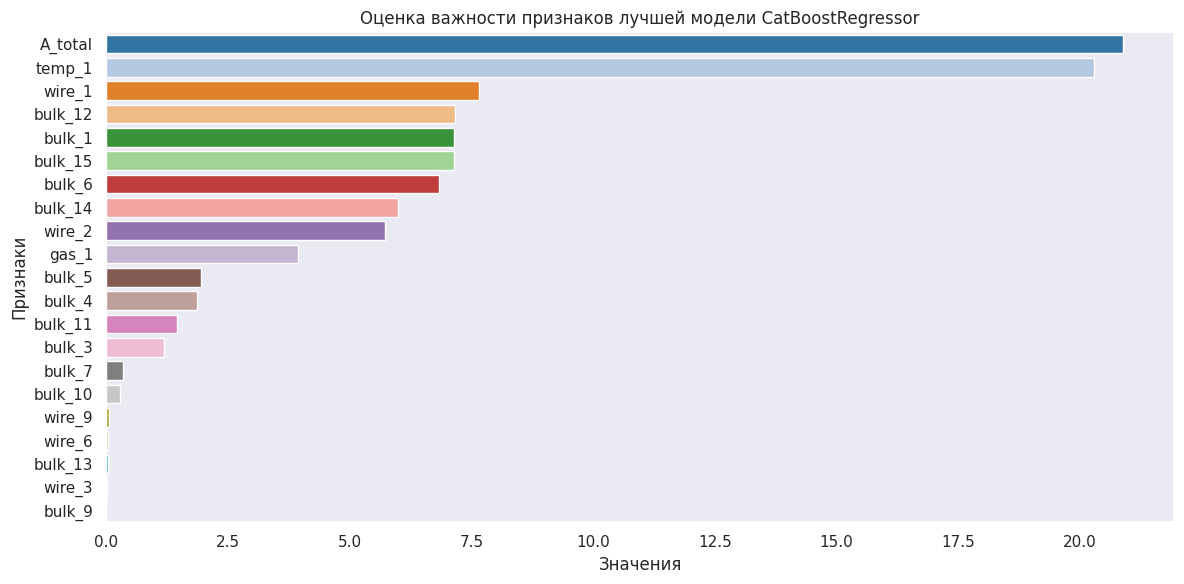

In [ ]:
graph_features (feature_importances_gs, features_test_scale, 'лучшей модели CatBoostRegressor')

### **Вывод:**
- Провела перекрестную проверку моделей - лучшей себя показала **CatBoostRegressor**: **MAE = 6.53**.
  > Худший результат выдала модель Линейной регресии: **MAE = 6.68**,
- Проверка модели на адекватность с помощью константной модели показала, что наша модель прошла проверку на вменяемость.
  > Значения MAE, показанные DummyRegressor, оказались значительно выше, чем у **CatBoost**
- Провела обучение и подбор параметров 5 моделей:
   - Модель **Линейной регрессии**
   - Модель **Случайного леса**
   - Модель **LightGBM**
   - Модель **CatBoost**
   - Модель **LGBMRegressor**
- Использовала методы: **RandomizedSearchCV** и **GridSearchCV**
- в итоге получила лучшую модель опять же **CatBoostRegressor** обоими методами с практически идентичными параметрами:
 >  `loss_function': 'MAE'`,` max_depth': 5`, `n_estimators': 100`
- Абсолютное среднее отклонение лучшей модели **CatBoostRegressor**, найденной методом `GridSCV`: `MAE_train = 6.39` с минимальной разницей от модели найденной методом **RandomizedSearchCV**.
- Тем не менее, на тестовой выборке лучший результат показала модель **CatBoostRegressor**, полученная методом **GridSearchCV**:
  > Абсолютное среднее отклонение лучшей модели, найденной методом **GridSearchCV**: **MAE_test = 6.39**
- и я бы в принципе при таких результатах выбрала бы именно метод **RandomizedSearchCV**, так как поиск модели занимает значительно меньше времени t = 9.02 сек, в отличие от **GridSearchCV** t = 6 минут.

- Тем не менее останавливаемся на модели, как лучшей,
  - **CatBoostRegressor**: `loss_function': 'MAE'`,` max_depth': 5`, `n_estimators': 100`,
  - полученной методом **GridSearchCV**
  - **MAE_test = 6.39**
- при анализу важности признаков выявилось, что наиболее важными признаками являются полная работа `А`, температура и `wire_1`.

# **4. ОТЧЕТ по проекту "Прогнозирование температуры плавления стали"**
### **Цель проекта**
Для оптимизации производственных расходов, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

Необходимо построить модель, которая предскажет температуру стали.

### **Входящие данные**
Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### **Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### **План работы**
1. Подготовка и анализ данных (EDA)
2. Предобработка данных
  - Удаление аномалий и работа с пропусками, формирование общего датасета.
  - Генерация ряда признаков.
  - Разделение общего датасета на выборки для обучения и проверки модели.
  - Масштабирование признаков - стандартизация данных
3. Обучение моделей:
  > `Линейной регрессии`,`Случайного леса`, `LightGBM`, `CatBoost`, `XGBRegressor`

  - Анализ моделей путем перекрестной проверки данных с использованием метрики показателя эффективности **MAE**
  - Обучение и подбор параметров моделей. Выбор лучшей методами:
       - **GridSearchCV**
       - **Randomized Search CV**
  - Проверка лучшей модели на тестовой выборке.
  - Исследование значимости признаков лучшей модели.
4. Выводы

### **Показатели:**
- основной показатель для оценки модели среднее асолютное отклонение - **MAE**
- модель считаем хорошей при значении **MAE < 6.8**.

###1. Что сделано:
Все пункты плана были выполнены, критических отклонений не было:
- поведен анализ данных:
 - выявила, что большинство данных соответствует нормальному распределению - это задача регрессии.
 - было выявлено несколько явных аномалий, некоторые значения данных не могут быть реальными исходя из технологического процесса:
   - отрицательное давление;
   - температурное значерие менее `1450` градусов. Так как у нас процесс производства стали, а температура плавления стали не может быть ниже этого значения.
   - все остальные значения укладываются в производственный процесс.
 - найдено 19% пропусков в данных о температуре
 - также найдено большое количество пропусков в данных о подаче сыпучих и провоочных материалов, но считаю это нормальным, так ак не все материалы должны использоваться на разных этапах технологического процесса - поэтому приняла решение заменить пропуски на `0`.
 - выявила, что в августе месяце наблюдался простой в производстве.
- удалила пропуски и неинформативные данные, в принципе поработала со всеми датафреймами. Сформировала итоговый датафрейм.
 - ввела несколько новых признаков:
>  *$A_t$* - общая работа при нагреве электродов, это позволило удалить признаки мощности и времени, что уменьшило объем датафрейма без потери качества и возможных утечек.
$$
 A_t = S*(t_2-t_1)
$$
 где: *S* — полная мощность,
 а *$t_2-t_1$* — период времени итерации

 - Определила `temp_2`(конечная температура), в качестве целевого признака - ведь по задаче именно ее мы должны ее определять.
- Разделила на выборки в пропорции 0.25, провела масштабирование признаков - данные улучшились.

- Проверила 5 моделей на кросс-валидации - лучший результат показала **CatBoostRegressor**: **MAE = 6.60**.
- методами **RandomizedSearchCV** и **GridSearchCV** получила лучшую модель
- протестировала лучшую модель,
- проранжировала признаки по важности:
> наиболее важными признаками являются полная работа `А`, температура и `wire_1`.

###2. Трудности:
- изначально сложности были в определении конечного целевого признака - в итоге целевым признаком определила температуру (ее конечное значение по каждой итерации процесса)
- вообще были сложности в выделении нужных температур из датасета - где-то не хватало итоговой температуры, где-то начальной - возможно не все данные фиксировались и заполнялись в датафрейм. В итоге принято решение неинформативные пропуски убрать, оставить только данные где по каждой итерации есть и начальная, и конечная температура сразу.
Технически это было придумать не так просто. Но в итоге все сделала.
- также много пропусков в данных по подаче материалов, нужно было понять, какие данные вообще нужны были для решения нашей задачи. Так так в принципе много признаков с минимальным количеством данных получалось. - в результате функцией `phik` проверила какие данные сильно коррелируют (коэф корр>80) друг с другом и удалила их.
> Если использовать именно функцию `phik` - выявляется достаточно большоке количество сильно коррелирующих признаков, было непросто не удалять их в большом количестве (решила, что можно будет потом проверить их на важность и улучшить модель)
- датасет был разрозенный - для структуризации подготовки данных надо было приложить усилия, думаю с опытом должна отработать этот навык, чтобы быстрее все делать.
- сложно было вытащить данные о важности признаков из pipeline, в итоге доступ к регрессору получила с помощью:
```
feature_importances_gs = gs.best_estimator_._final_estimator.feature_importances_
```

###3. Ключевые шаги для решения задачи:
- описание ключевых шагов решения
  - подготовка данных - анализ и приведение в нужный формат
  - предобработка:
    - удаление или намена данными пропусков
    - удаление аномалий
    - формирование общего датасета
    - определение тех признаки, которые позволят наиболее эффективно обучить нашу модель
    - определиться с целевым признаком и метрикой качества.
  - обучение моделей, выбор лучшей и её тестирование:
    - подобрать лучшую модель (определить те модели, которые буду проверять)
    - выбор лучшей модели
    - тестирование модели
    - проверка на важноть признаков
> Все поплану - стандарной работы ML

###4. Признаки для обучения модели:
Использовала следующие признаки для обучения модели:
```
['A_total', 'temp_1', 'temp_2', 'wire_1', 'wire_2', 'wire_3', 'wire_6',
       'wire_9', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'gas_1']
```

###5. Итоговая модель, ее гиперпараметры и качество:
В итоге получила лучшую модель:
  -  **CatBoostRegressor** со следующими гиперпараметрами:
```
'learning_rate': 0.1,
'loss_function': 'MAE',
'max_depth': 5,
'n_estimators': 100
```
  - полученной методом **GridSearchCV**`(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')`

###6. Итоговая метрика:
 Метрика качества (среднее абсолютное отклонение) на тесте **MAE_test = 6.39**
- при анализе важности признаков выявилось, что наиболее важными признаками являются полная работа `А`, температура и `wire_1`.

###7. Рекомендации по улучшению решения:
 Для улучшения  модели в дальнейшем можно поработать по удалению признаков с низкой важностью (их довольно много), а также порпобовать бодобрать более шировкий спектр гиперпараметров.

